# Titanic Kaggle Competition

<center><img src="titanic-anniversary-sai-2-embed-02.jpg" alt="Titanic" width="500" height="600""></center>

## Introduction

This project is in association with the Kaggle Titanic Competition.  The goal of this project is to process a dataset of the passengers of the ill-fated voyage of the Titanic and build a binary classifier to determine whether a passenger survives.  

### Imports

In [1]:
import numpy as np
import tensorflow as tf

# Random Seed
np.random.seed(30)
tf.random.set_seed(30)

In [2]:
# The standards
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
import shap
shap.initjs()

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC

# Model Validation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score

# Make pandas display all columns
pd.set_option('display.max_columns', None)

# Sklearn Display
from sklearn import set_config
set_config(display = 'diagram')


Bad key "text.kerning_factor" on line 4 in
/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Functions

#### Preprocessing Functions

In [3]:
def get_info(df):
    print('-----  Shape  -----')
    print(df.shape)
    print('\n')
    print('-----  Info  -----')
    print(df.info())
    print('\n')
    print('-----  Describe  -----')
    print(df.describe())
    print('\n')
    print('-----  Nulls  -----')
    print(df.isna().sum())
    

def get_titles(column):
    titles = []
    for name in train_df['Name']:
        name = name.split(',')[1]
        name = name.split('.')[0]
        titles.append(name)
        
    return titles


def get_last_names(column):
    last_names = []
    for name in column:
        name = name.split(',')[0]
        last_names.append(name)

    return last_names


def preprocessing(df, name_column):
    from sklearn.compose import ColumnTransformer
    # Cabin Column
    df['Cabin'].fillna(value = 'Missing', inplace = True)
    
    # Create cabin_level
    cabin_level = []
    for i in df['Cabin']:
        i = str(i)
        i = i[0]
        cabin_level.append(i)
    df['Cabin Level'] = cabin_level
    
    # Create Family Size 
    df['Family Size'] = df['Parch'] + df['SibSp'] + 1
    
    # Create Titles Column
    titles = []
    for name in name_column:
        name = name.split(',')[1]
        name = name.split('.')[0]
        titles.append(name)
    df['Title'] = titles
    
    # Create Last Name Column
    last_names = []
    for name in name_column:
        name = name.split(',')[0]
        last_names.append(name)
    df['Last Name'] = last_names
    df.drop('Name', axis = 1, inplace = True)
    
    # Drop Ticket Column
    df.drop('Ticket', axis = 1, inplace = True)
    
    # Create Age Group Column
    df['Age Group'] = df['Age'].copy()
    bins = [0, 12, 20, 30, 64, 65]
    labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
    df['Age Group'] = pd.cut(df['Age Group'], bins = bins, labels = labels, right = False)
    
    # Split numercial and categorical columns
    num_cols = df.select_dtypes('number').columns
    cat_cols = df.select_dtypes('O').columns
    
    # Transform numerical columns
    num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), 
                                    ('scaler', MinMaxScaler())])
    
    # Transform categorical columns 
    cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')), 
                                    ('encoder', OneHotEncoder(handle_unknown = 'ignore', 
                                                              sparse = False))])
    
    # Create final processed dataframe
    preprocessing = ColumnTransformer(transformers = [('num', num_transformer, num_cols),
                                                  ('cat', cat_transformer, cat_cols)])
    df_processed = preprocessing.fit_transform(df)
    slice_pipe = preprocessing.named_transformers_['cat']
    cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)
    
    final_df = pd.DataFrame(df_processed, columns = [*num_cols, *cat_features])
    
    return final_df

#### Plotting Functions

In [4]:
def evaluate_model(model, X_test, y_test):
    '''Evaluates a sklearn classifier model by displaying a classification report, 
    a confusion matrix plot, and a ROC-AUC plot.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix
    fig, axes = plt.subplots(figsize = (12,6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])#, labels = ['Survived', 'Died'])
    axes[0].set_title('Confusion Matrix');
    
    # ROC-AUC Curve
    roc_auc_plot = plot_roc_curve(model, X_test, y_test, ax = axes[1])
    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show();
    
    
def evaluate_voting_model(model, X_test, y_test):
    '''Evaluates a sklearn classifier model by displaying a classification report, 
    a confusion matrix plot, and a ROC-AUC plot.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix
    fig, axes = plt.subplots(figsize = (12,6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])#, labels = ['Survived', 'Died'])
    axes[0].set_title('Confusion Matrix');
    

def network_eval_plots(results):
    '''Visualizes the loss and accuracy curves of the training set and validation set.'''
    
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();
    

def nn_confusion_matrix(y_test, preds):
    '''Creates a confusion matrix specifically for neural networks.'''

    cm = confusion_matrix(y_test, preds, normalize = 'true')
    ax = plt.figure(figsize = (6, 6))
    ax = sns.heatmap(cm, cmap = 'Blues', annot = True,
                     xticklabels = ['Died', 'Survived'],
                     yticklabels = ['Died', 'Survived'])
    ax.set_ylim([0,2])
    
    
def evaluate_network(results, model, X_test, y_test):
    preds = model.predict(X_test).round()
    print('                 Model Evaluation')
    print('-------------------------------------------------------')
    print(model.evaluate(X_test, y_test))
    print(' ')
    print('                 Loss & Accuracy Curves')
    print('-------------------------------------------------------')
    network_eval_plots(results)
    print(' ')
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, preds))
    print(' ')    
    print('                 Confusion Matrix')
    print('-------------------------------------------------------')
    nn_confusion_matrix(y_test, preds)

#### Modeling Functions

In [5]:
def sklearn_model(model, X_train, y_train, X_test, y_test):
    sklearn_model = model()
    sklearn_model.fit(X_train, y_train)
    
    # Predictions
    y_hat_test = sklearn_model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix
    fig, axes = plt.subplots(figsize = (12,6), ncols = 2)
    plot_confusion_matrix(sklearn_model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])#, labels = ['Survived', 'Died'])
    axes[0].set_title('Confusion Matrix');
    
    # ROC-AUC Curve
    roc_auc_plot = plot_roc_curve(sklearn_model, X_test, y_test, ax = axes[1])
    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show();
    

def neural_network(X_train, y_train, X_test, y_test, epochs, batch_size):
    # Model
    model = Sequential()
    model.add(Dense(128, input_shape = X_train.shape, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    #Compile
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
    # Fit
    history = model.fit(X_train_df, y_train, batch_size = batch_size, epochs = epochs,
                        validation_split = 0.3)
    
    # Evaluate
    preds = model.predict(X_test).round()
    print('                 Model Evaluation')
    print('-------------------------------------------------------')
    print(model.evaluate(X_test, y_test))
    print(' ')
    print('                 Loss & Accuracy Curves')
    print('-------------------------------------------------------')
    network_eval_plots(history)
    print(' ')
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, preds))
    print(' ')    
    print('                 Confusion Matrix')
    print('-------------------------------------------------------')
    nn_confusion_matrix(y_test, preds)

## Obtain

### Training Data

In [6]:
# Create dataframe for training data

train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Data

In [7]:
# Create dataframe for test data

test_df = pd.read_csv('test.csv')
print(test_df.shape)
test_df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Scrub

> Just a quick exploration here to see what we're working with.

In [8]:
# Let's check out the data real quick

display(test_df.head())
display(train_df.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Get some info on the training data

get_info(train_df)

-----  Shape  -----
(891, 12)


-----  Info  -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


-----  Describe  -----
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0

In [10]:
# Get some info on the test data

get_info(test_df)

-----  Shape  -----
(418, 11)


-----  Info  -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


-----  Describe  -----
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0

In [11]:
# Can drop the passenger id column

train_df.drop('PassengerId', axis = 1, inplace = True)
test_df.drop('PassengerId', axis = 1, inplace = True)

### Null Values

In [12]:
# Check the number of null values of the training data

train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [13]:
# Check the number of null values of the test data


test_df.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

### Feature Selection & Engineering

#### Cabin

In [14]:
# Let's check out the values of the Cabin column

train_df['Cabin'].value_counts().sort_values(ascending = False) 

B96 B98        4
G6             4
C23 C25 C27    4
D              3
C22 C26        3
              ..
C70            1
E38            1
C148           1
E46            1
A32            1
Name: Cabin, Length: 147, dtype: int64

In [15]:
# Fill the null values in Cabin with 'Missing'

train_df['Cabin'].fillna(value = 'Missing', inplace = True)
train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin         0
Embarked      2
dtype: int64

In [16]:
# Create a new column 'Cabin Level' with just the letter associated with the cabin

cabin_level = []
for i in train_df['Cabin']:
    i = str(i)
    i = i[0]
    cabin_level.append(i)
    
train_df['Cabin Level'] = cabin_level

# Drop the cabin column
train_df.drop('Cabin', axis = 1, inplace = True)

# Make sure this all worked!
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M


#### Parch & SibSp

In [17]:
# Check the Parch values

train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [18]:
# Check the SibSp values

train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [19]:
#  Create a new column called Family Size

train_df['Family Size'] = train_df['Parch'] + train_df['SibSp'] + 1
train_df['Family Size'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family Size, dtype: int64

In [20]:
# Make Sure this worked

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level,Family Size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M,1


#### Name

> So this could be interesting.  We can make the assumption that each full name on the Titanic is unique.  However, if we were to slice out just the last name, we could see if there is any correlation between last name (family) and survival.

In [21]:
# Checking the assumption that each name is unique.

train_df['Name'].value_counts()

Morley, Mr. William                                1
Sandstrom, Miss. Marguerite Rut                    1
Aks, Mrs. Sam (Leah Rosen)                         1
Leitch, Miss. Jessie Wills                         1
Peter, Miss. Anna                                  1
                                                  ..
Mineff, Mr. Ivan                                   1
Skoog, Mrs. William (Anna Bernhardina Karlsson)    1
del Carlo, Mr. Sebastiano                          1
Hale, Mr. Reginald                                 1
Pears, Mrs. Thomas (Edith Wearne)                  1
Name: Name, Length: 891, dtype: int64

##### Title

In [22]:
# Create the titles column

train_df['Title'] = get_titles(train_df['Name'])
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level,Family Size,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M,2,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,2,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,2,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M,1,Mr


In [23]:
# Checking the titles value counts

train_df['Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 Ms                1
 Mme               1
 Don               1
 Sir               1
 the Countess      1
 Capt              1
 Jonkheer          1
 Lady              1
Name: Title, dtype: int64

##### Last Name

In [24]:
# Create Last Name and drop name

train_df['Last Name'] = get_last_names(train_df['Name'])
train_df.drop('Name', axis = 1, inplace = True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level,Family Size,Title,Last Name
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,M,2,Mr,Braund
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C,2,Mrs,Cumings
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1,Miss,Heikkinen
3,1,1,female,35.0,1,0,113803,53.1000,S,C,2,Mrs,Futrelle
4,0,3,male,35.0,0,0,373450,8.0500,S,M,1,Mr,Allen


In [25]:
# Check value counts

print(train_df['Last Name'].value_counts())

Andersson    9
Sage         7
Goodwin      6
Johnson      6
Panula       6
            ..
Shellard     1
Seward       1
Myhrman      1
Sutehall     1
Cribb        1
Name: Last Name, Length: 667, dtype: int64


> As expected, there are multiple people with the same last name, potentially indicating full families on board.

#### Ticket

In [26]:
# Checking the values in the Ticket column

train_df['Ticket'].value_counts()

347082               7
1601                 7
CA. 2343             7
3101295              6
347088               6
                    ..
3101277              1
365226               1
STON/O 2. 3101288    1
244373               1
374887               1
Name: Ticket, Length: 681, dtype: int64

In [27]:
for i in train_df['Ticket']:
    print(i)

A/5 21171
PC 17599
STON/O2. 3101282
113803
373450
330877
17463
349909
347742
237736
PP 9549
113783
A/5. 2151
347082
350406
248706
382652
244373
345763
2649
239865
248698
330923
113788
349909
347077
2631
19950
330959
349216
PC 17601
PC 17569
335677
C.A. 24579
PC 17604
113789
2677
A./5. 2152
345764
2651
7546
11668
349253
SC/Paris 2123
330958
S.C./A.4. 23567
370371
14311
2662
349237
3101295
A/4. 39886
PC 17572
2926
113509
19947
C.A. 31026
2697
C.A. 34651
CA 2144
2669
113572
36973
347088
PC 17605
2661
C.A. 29395
S.P. 3464
3101281
315151
C.A. 33111
CA 2144
S.O.C. 14879
2680
1601
348123
349208
374746
248738
364516
345767
345779
330932
113059
SO/C 14885
3101278
W./C. 6608
SOTON/OQ 392086
19950
343275
343276
347466
W.E.P. 5734
C.A. 2315
364500
374910
PC 17754
PC 17759
231919
244367
349245
349215
35281
7540
3101276
349207
343120
312991
349249
371110
110465
2665
324669
4136
2627
STON/O 2. 3101294
370369
11668
PC 17558
347082
S.O.C. 14879
A4. 54510
237736
27267
35281
2651
370372
C 17369
2668
3470

In [28]:
train_df.drop('Ticket', axis = 1, inplace = True)

#### Age Group
> Let's create a categorical age group column.

In [29]:
train_df['Age Group'] = train_df['Age'].copy()

In [30]:
bins = [0, 12, 20, 30, 64, 65]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

train_df['Age Group'] = pd.cut(train_df['Age Group'], bins = bins, labels = labels, right = False)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin Level,Family Size,Title,Last Name,Age Group
0,0,3,male,22.0,1,0,7.2500,S,M,2,Mr,Braund,Young Adult
1,1,1,female,38.0,1,0,71.2833,C,C,2,Mrs,Cumings,Adult
2,1,3,female,26.0,0,0,7.9250,S,M,1,Miss,Heikkinen,Young Adult
3,1,1,female,35.0,1,0,53.1000,S,C,2,Mrs,Futrelle,Adult
4,0,3,male,35.0,0,0,8.0500,S,M,1,Mr,Allen,Adult


### Train Test Split & Preprocessing

In [31]:
# Create X & y

X = train_df.drop('Survived', axis = 1)
y = train_df['Survived']

In [32]:
# Create train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(668, 12)
(223, 12)
(668,)
(223,)


In [33]:
# Split into numerical and categorical columns

num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('O').columns

In [34]:
# Create pipeline for numerical columns

# num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), 
#                                     ('scaler', StandardScaler())])

num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), 
                                    ('scaler', MinMaxScaler())])

num_transformer

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                ('scaler', MinMaxScaler())])

In [35]:
# Create pipeline for categorical columns

cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')), 
                                    ('encoder', OneHotEncoder(handle_unknown = 'ignore', 
                                                              sparse = False))])
cat_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [36]:
# Combine pipelines into a single pipeline

preprocessing = ColumnTransformer(transformers = [('num', num_transformer, num_cols),
                                                  ('cat', cat_transformer, cat_cols)])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('scaler', MinMaxScaler())]),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family Size'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Sex', 'Embarked', 'Cabin Level', 'Title', 'Last Name'], dtype='object'))])

In [37]:
# Fit the training data with the pipeline

X_train_processed = preprocessing.fit_transform(X_train)
X_test_processed = preprocessing.transform(X_test)

In [38]:
# Put back into a dataframe

slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)

In [39]:
# Let's check out what we have

X_train_df = pd.DataFrame(X_train_processed, columns = [*num_cols, *cat_features])
X_test_df = pd.DataFrame(X_test_processed, columns = [*num_cols, *cat_features])

print(X_train_df.shape)
display(X_train_df.head())
print(X_test_df.shape)
display(X_test_df.head())

(668, 568)


,Pclass,Age,SibSp,Parch,Fare,Family Size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin Level_A,Cabin Level_B,Cabin Level_C,Cabin Level_D,Cabin Level_E,Cabin Level_F,Cabin Level_G,Cabin Level_M,Cabin Level_T,Title_ Col,Title_ Don,Title_ Dr,Title_ Lady,Title_ Major,Title_ Master,Title_ Miss,Title_ Mlle,Title_ Mme,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Title_ Sir,Last Name_Abbing,Last Name_Abbott,Last Name_Abelson,Last Name_Adahl,Last Name_Adams,Last Name_Aks,Last Name_Albimona,Last Name_Alexander,Last Name_Ali,Last Name_Allen,Last Name_Allison,Last Name_Anderson,Last Name_Andersson,Last Name_Andreasson,Last Name_Andrew,Last Name_Angle,Last Name_Appleton,Last Name_Arnold-Franchi,Last Name_Asim,Last Name_Asplund,Last Name_Astor,Last Name_Attalah,Last Name_Aubart,Last Name_Augustsson,Last Name_Ayoub,Last Name_Backstrom,Last Name_Baclini,Last Name_Badt,Last Name_Balkic,Last Name_Ball,Last Name_Banfield,Last Name_Barah,Last Name_Barbara,Last Name_Bateman,Last Name_Baumann,Last Name_Baxter,Last Name_Bazzani,Last Name_Beane,Last Name_Beavan,Last Name_Becker,Last Name_Beckwith,Last Name_Behr,Last Name_Bengtsson,Last Name_Berglund,Last Name_Betros,Last Name_Bidois,Last Name_Birkeland,Last Name_Bishop,Last Name_Bissette,Last Name_Bjornstrom-Steffansson,Last Name_Blackwell,Last Name_Bonnell,Last Name_Boulos,Last Name_Bourke,Last Name_Bowen,Last Name_Bowerman,Last Name_Bracken,Last Name_Bradley,Last Name_Braund,Last Name_Brewe,Last Name_Brocklebank,Last Name_Brown,Last Name_Burke,Last Name_Burns,Last Name_Butler,Last Name_Butt,Last Name_Byles,Last Name_Bystrom,Last Name_Cacic,Last Name_Cairns,Last Name_Calderhead,Last Name_Caldwell,Last Name_Calic,Last Name_Cameron,Last Name_Campbell,Last Name_Cann,Last Name_Carlsson,Last Name_Carr,Last Name_Carrau,Last Name_Carter,Last Name_Cavendish,Last Name_Celotti,Last Name_Chaffee,Last Name_Chambers,Last Name_Chapman,Last Name_Charters,Last Name_Chibnall,Last Name_Chip,Last Name_Christmann,Last Name_Christy,Last Name_Chronopoulos,Last Name_Clarke,Last Name_Cleaver,Last Name_Clifford,Last Name_Coelho,Last Name_Cohen,Last Name_Coleff,Last Name_Coleridge,Last Name_Collander,Last Name_Colley,Last Name_Collyer,Last Name_Compton,Last Name_Connolly,Last Name_Connors,Last Name_Cook,Last Name_Cor,Last Name_Coutts,Last Name_Coxon,Last Name_Crease,Last Name_Cribb,Last Name_Crosby,Last Name_Culumovic,Last Name_Cumings,Last Name_Dahlberg,Last Name_Dakic,Last Name_Daly,Last Name_Danbom,Last Name_Daniel,Last Name_Danoff,Last Name_Dantcheff,Last Name_Davies,Last Name_Davis,Last Name_Davison,Last Name_Dean,Last Name_Denkoff,Last Name_Dennis,Last Name_Devaney,Last Name_Dick,Last Name_Dimic,Last Name_Dodge,Last Name_Doharr,Last Name_Doling,Last Name_Dorking,Last Name_Dowdell,Last Name_Downton,Last Name_Drazenoic,Last Name_Drew,Last Name_Duane,Last Name_Duff Gordon,Last Name_Duran y More,Last Name_Edvardsson,Last Name_Eitemiller,Last Name_Eklund,Last Name_Ekstrom,Last Name_Elias,Last Name_Elsbury,Last Name_Emanuel,Last Name_Emir,Last Name_Endres,Last Name_Eustis,Last Name_Fahlstrom,Last Name_Farrell,Last Name_Farthing,Last Name_Fischer,Last Name_Fleming,Last Name_Flynn,Last Name_Foo,Last Name_Ford,Last Name_Foreman,Last Name_Fortune,Last Name_Francatelli,Last Name_Frauenthal,Last Name_Frolicher,Last Name_Frost,Last Name_Funk,Last Name_Fynney,Last Name_Gaskell,Last Name_Gavey,Last Name_Gee,Last Name_Gheorgheff,Last Name_Giglio,Last Name_Giles,Last Name_Gill,Last Name_Gillespie,Last Name_Gilnagh,Last Name_Givard,Last Name_Glynn,Last Name_Goldenberg,Last Name_Goldschmidt,Last Name_Goldsmith,Last Name_Goncalves,Last Name_Goodwin,Last Name_Graham,Last Name_Greenberg,Last Name_Greenfield,Last Name_Guggenheim,Last Name_Gustafsson,Last Name_Haas,Last Name_Hagland,Last Name_Hakkarainen,Last Name_Hale,Last Name_Hamalainen,Last Name_Hampe,Last Name_Hanna,Last Name_Hansen,Last Name_Harder,Last Name_Harknett,Last Name_Harmer,Last Name_Harper,Last Name_Harrington,Last Name_Harris,Last Name_Harrison,Last Name_Hart,Last 

(223, 568)


,Pclass,Age,SibSp,Parch,Fare,Family Size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin Level_A,Cabin Level_B,Cabin Level_C,Cabin Level_D,Cabin Level_E,Cabin Level_F,Cabin Level_G,Cabin Level_M,Cabin Level_T,Title_ Col,Title_ Don,Title_ Dr,Title_ Lady,Title_ Major,Title_ Master,Title_ Miss,Title_ Mlle,Title_ Mme,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Title_ Sir,Last Name_Abbing,Last Name_Abbott,Last Name_Abelson,Last Name_Adahl,Last Name_Adams,Last Name_Aks,Last Name_Albimona,Last Name_Alexander,Last Name_Ali,Last Name_Allen,Last Name_Allison,Last Name_Anderson,Last Name_Andersson,Last Name_Andreasson,Last Name_Andrew,Last Name_Angle,Last Name_Appleton,Last Name_Arnold-Franchi,Last Name_Asim,Last Name_Asplund,Last Name_Astor,Last Name_Attalah,Last Name_Aubart,Last Name_Augustsson,Last Name_Ayoub,Last Name_Backstrom,Last Name_Baclini,Last Name_Badt,Last Name_Balkic,Last Name_Ball,Last Name_Banfield,Last Name_Barah,Last Name_Barbara,Last Name_Bateman,Last Name_Baumann,Last Name_Baxter,Last Name_Bazzani,Last Name_Beane,Last Name_Beavan,Last Name_Becker,Last Name_Beckwith,Last Name_Behr,Last Name_Bengtsson,Last Name_Berglund,Last Name_Betros,Last Name_Bidois,Last Name_Birkeland,Last Name_Bishop,Last Name_Bissette,Last Name_Bjornstrom-Steffansson,Last Name_Blackwell,Last Name_Bonnell,Last Name_Boulos,Last Name_Bourke,Last Name_Bowen,Last Name_Bowerman,Last Name_Bracken,Last Name_Bradley,Last Name_Braund,Last Name_Brewe,Last Name_Brocklebank,Last Name_Brown,Last Name_Burke,Last Name_Burns,Last Name_Butler,Last Name_Butt,Last Name_Byles,Last Name_Bystrom,Last Name_Cacic,Last Name_Cairns,Last Name_Calderhead,Last Name_Caldwell,Last Name_Calic,Last Name_Cameron,Last Name_Campbell,Last Name_Cann,Last Name_Carlsson,Last Name_Carr,Last Name_Carrau,Last Name_Carter,Last Name_Cavendish,Last Name_Celotti,Last Name_Chaffee,Last Name_Chambers,Last Name_Chapman,Last Name_Charters,Last Name_Chibnall,Last Name_Chip,Last Name_Christmann,Last Name_Christy,Last Name_Chronopoulos,Last Name_Clarke,Last Name_Cleaver,Last Name_Clifford,Last Name_Coelho,Last Name_Cohen,Last Name_Coleff,Last Name_Coleridge,Last Name_Collander,Last Name_Colley,Last Name_Collyer,Last Name_Compton,Last Name_Connolly,Last Name_Connors,Last Name_Cook,Last Name_Cor,Last Name_Coutts,Last Name_Coxon,Last Name_Crease,Last Name_Cribb,Last Name_Crosby,Last Name_Culumovic,Last Name_Cumings,Last Name_Dahlberg,Last Name_Dakic,Last Name_Daly,Last Name_Danbom,Last Name_Daniel,Last Name_Danoff,Last Name_Dantcheff,Last Name_Davies,Last Name_Davis,Last Name_Davison,Last Name_Dean,Last Name_Denkoff,Last Name_Dennis,Last Name_Devaney,Last Name_Dick,Last Name_Dimic,Last Name_Dodge,Last Name_Doharr,Last Name_Doling,Last Name_Dorking,Last Name_Dowdell,Last Name_Downton,Last Name_Drazenoic,Last Name_Drew,Last Name_Duane,Last Name_Duff Gordon,Last Name_Duran y More,Last Name_Edvardsson,Last Name_Eitemiller,Last Name_Eklund,Last Name_Ekstrom,Last Name_Elias,Last Name_Elsbury,Last Name_Emanuel,Last Name_Emir,Last Name_Endres,Last Name_Eustis,Last Name_Fahlstrom,Last Name_Farrell,Last Name_Farthing,Last Name_Fischer,Last Name_Fleming,Last Name_Flynn,Last Name_Foo,Last Name_Ford,Last Name_Foreman,Last Name_Fortune,Last Name_Francatelli,Last Name_Frauenthal,Last Name_Frolicher,Last Name_Frost,Last Name_Funk,Last Name_Fynney,Last Name_Gaskell,Last Name_Gavey,Last Name_Gee,Last Name_Gheorgheff,Last Name_Giglio,Last Name_Giles,Last Name_Gill,Last Name_Gillespie,Last Name_Gilnagh,Last Name_Givard,Last Name_Glynn,Last Name_Goldenberg,Last Name_Goldschmidt,Last Name_Goldsmith,Last Name_Goncalves,Last Name_Goodwin,Last Name_Graham,Last Name_Greenberg,Last Name_Greenfield,Last Name_Guggenheim,Last Name_Gustafsson,Last Name_Haas,Last Name_Hagland,Last Name_Hakkarainen,Last Name_Hale,Last Name_Hamalainen,Last Name_Hampe,Last Name_Hanna,Last Name_Hansen,Last Name_Harder,Last Name_Harknett,Last Name_Harmer,Last Name_Harper,Last Name_Harrington,Last Name_Harris,Last Name_Harrison,Last Name_Hart,Last 

## Explore

In [40]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

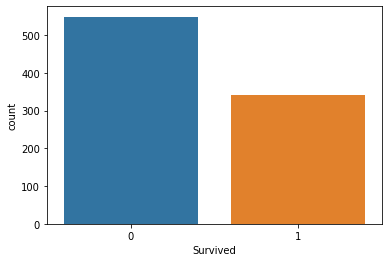

In [41]:
sns.countplot(data = train_df, x = 'Survived');

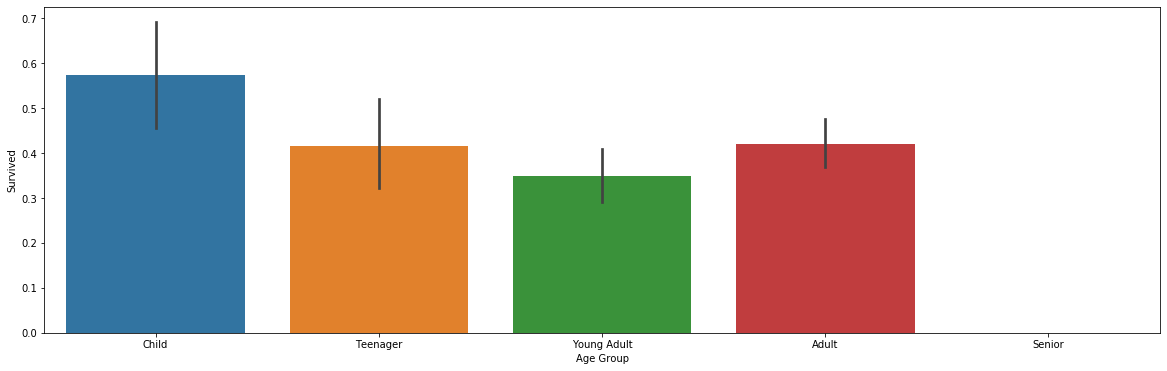

In [42]:
fig = plt.figure(figsize = (20, 6))
fig = sns.barplot(data = train_df, x = 'Age Group', y = 'Survived');

## Modeling

### Logistic Regression

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       131
           1       0.76      0.72      0.74        92

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



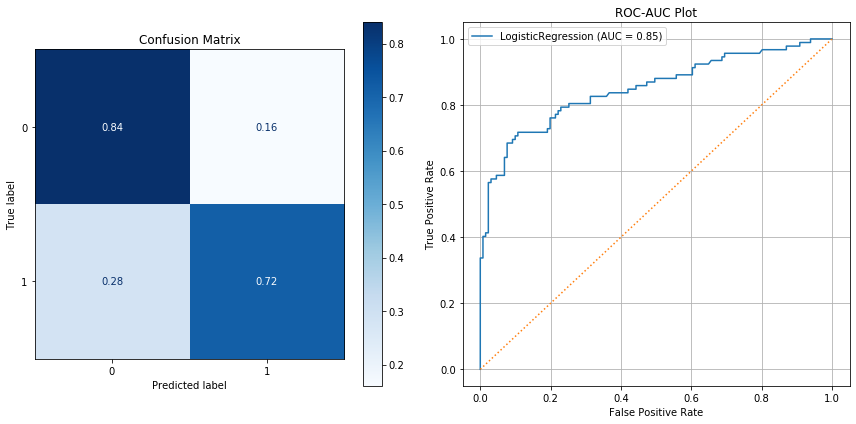

In [43]:
# Fit a base logistic regression model

logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train_df, y_train)

# Evaluate model
evaluate_model(logreg, X_test_df, y_test)

#### GridSearchCV

In [44]:
# Let's try using gridsearch to see if we can kick this up a notch

params = {'class_weight': ['balanced'],
          'solver' : ['lbfgs', 'liblinear', 'newton-cg'],
          'max_iter': [100, 200, 500],
          'penalty': ['l1', 'l2', 'none']}

logreg_grid = GridSearchCV(estimator = LogisticRegression(),
                           param_grid = params,
                           cv = 3,
                           scoring = 'recall',
                           n_jobs = -1)

logreg_grid.fit(X_train_df, y_train)

print(logreg_grid.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       131
           1       0.76      0.72      0.74        92

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



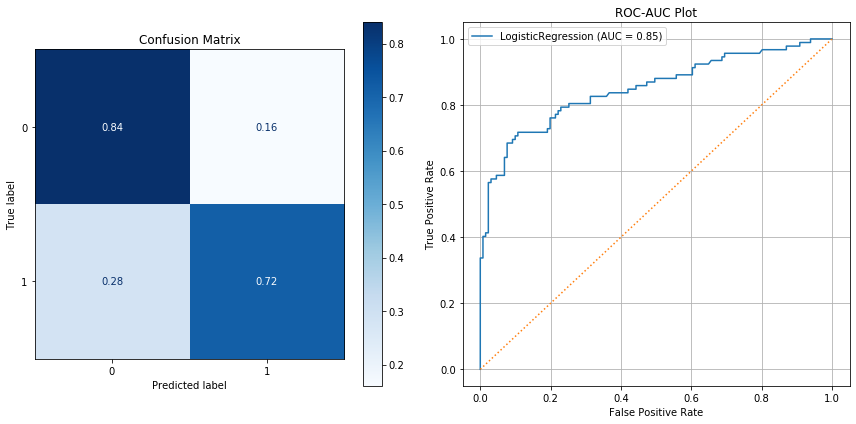

In [45]:
# Fit the model using the best parameters

best_logreg_params = logreg_grid.best_params_
best_logreg_model = LogisticRegression(**best_logreg_params)
best_logreg_model.fit(X_train_df, y_train)

# Evaluate the model
evaluate_model(best_logreg_model, X_test_df, y_test)

### Decision Tree

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       131
           1       0.79      0.70      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



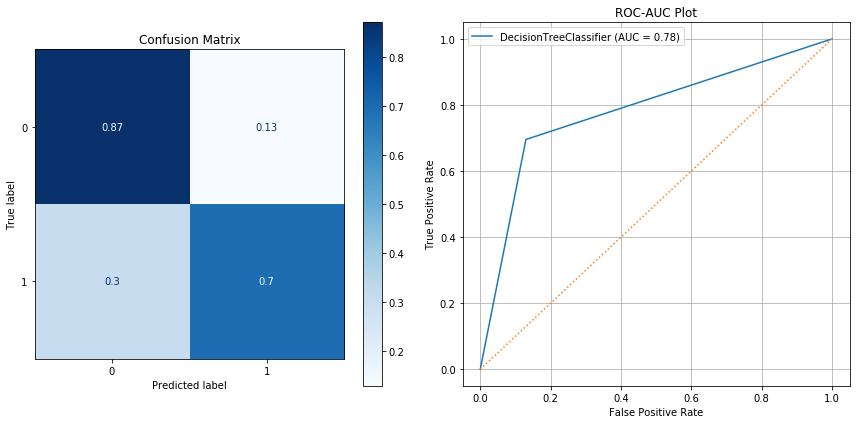

In [46]:
# Fitting a base Decision Tree

tree = DecisionTreeClassifier(class_weight = 'balanced')
tree.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(tree, X_test_df, y_test)

#### GridsearchCV

In [47]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced'],
          'splitter' : ['best', 'random'],
          'max_features': [None, "auto", "sqrt", "log2"],
          'criterion': ['gini', 'entropy'],
          'max_depth' : [1, 5, 10, 25], 
          'min_samples_split' : [2, 5, 10],
          'min_samples_leaf' : [1, 5, 10]}

tree_grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = params,
                    cv = 3,
                    n_jobs = -1)

tree_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(tree_grid.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'random'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       131
           1       0.79      0.74      0.76        92

    accuracy                           0.81       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



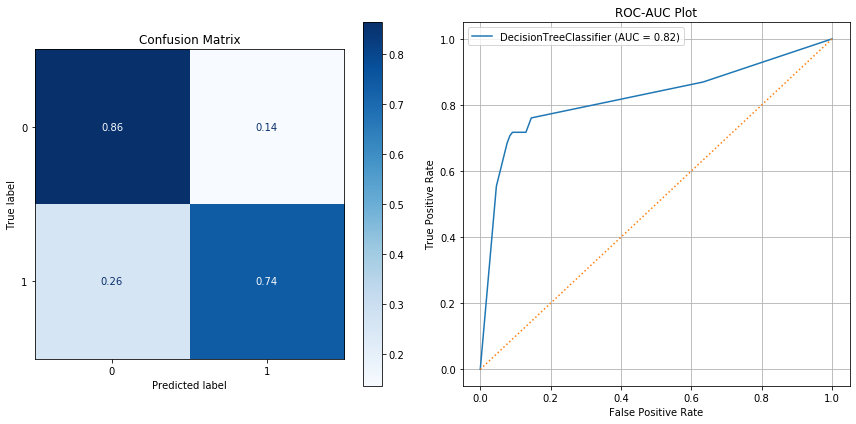

In [48]:
# Fit new model with the best hyperparameters

best_tree_params = tree_grid.best_params_
best_tree_model = DecisionTreeClassifier(**best_tree_params)
best_tree_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_tree_model, X_test_df, y_test)

### KNeighbors Classifier

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       131
           1       0.79      0.70      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



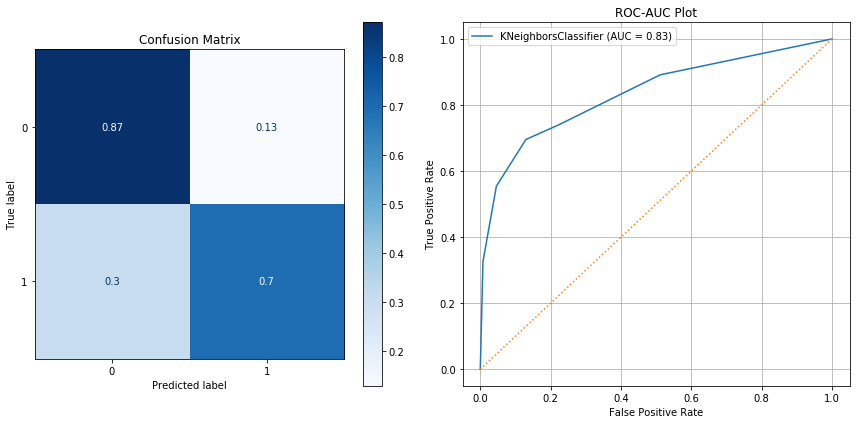

In [49]:
knn = KNeighborsClassifier()
knn.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(knn, X_test_df, y_test)

#### GridsearchCV

In [50]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_neighbors' : [1, 2, 3, 4, 5],
          'weights' : ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'leaf_size': [10, 30, 50]}

knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

knn_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(knn_grid.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       131
           1       0.76      0.65      0.70        92

    accuracy                           0.77       223
   macro avg       0.77      0.75      0.76       223
weighted avg       0.77      0.77      0.77       223



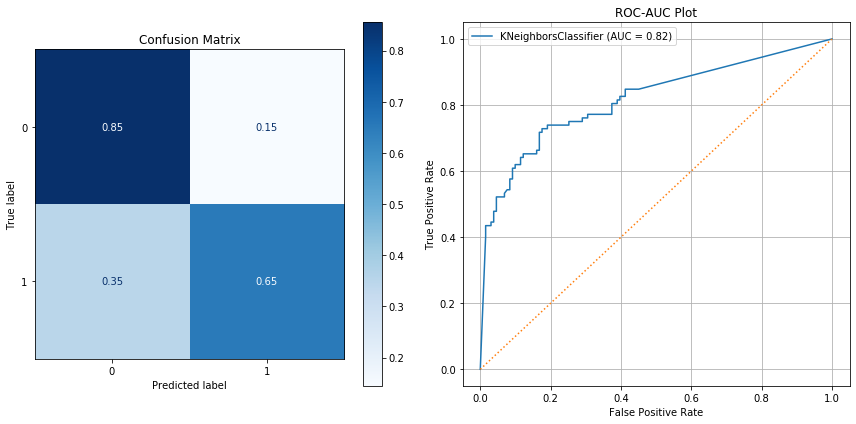

In [51]:
# Fit new model with the best hyperparameters

best_knn_params = knn_grid.best_params_
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_knn_model, X_test_df, y_test)

### MLP Classifier

#### Base Model

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       131
           1       0.78      0.67      0.72        92

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



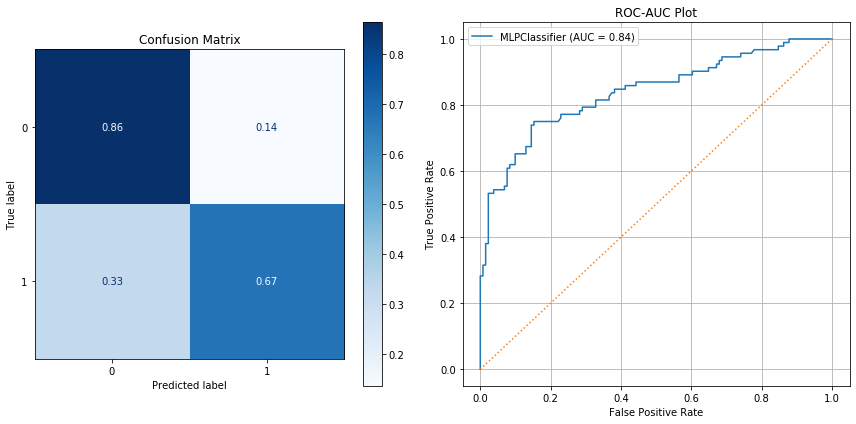

In [52]:
mlp = MLPClassifier()
mlp.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(mlp, X_test_df, y_test)

#### GridsearchCV

In [53]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'hidden_layer_sizes' : [(100,), (200,), (300,)],
          'activation' : ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['lbfgs', 'sgd', 'adam'],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
          'early_stopping': [True, False],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
         }

mlp_grid = GridSearchCV(estimator = MLPClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

mlp_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(mlp_grid.best_estimator_.get_params())

{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (300,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.84       131
           1       0.81      0.70      0.75        92

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.80       223



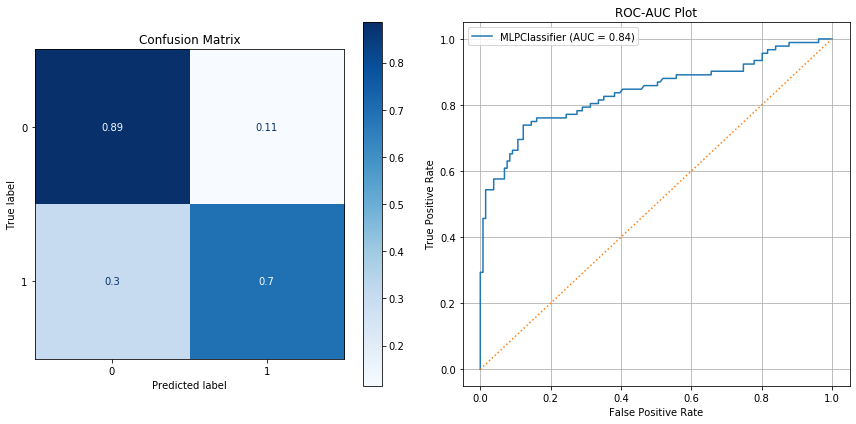

In [54]:
# Fit new model with the best hyperparameters

best_mlp_params = mlp_grid.best_params_
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_mlp_model, X_test_df, y_test)

### Guassian Process Classifier

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       131
           1       0.81      0.67      0.73        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.79       223



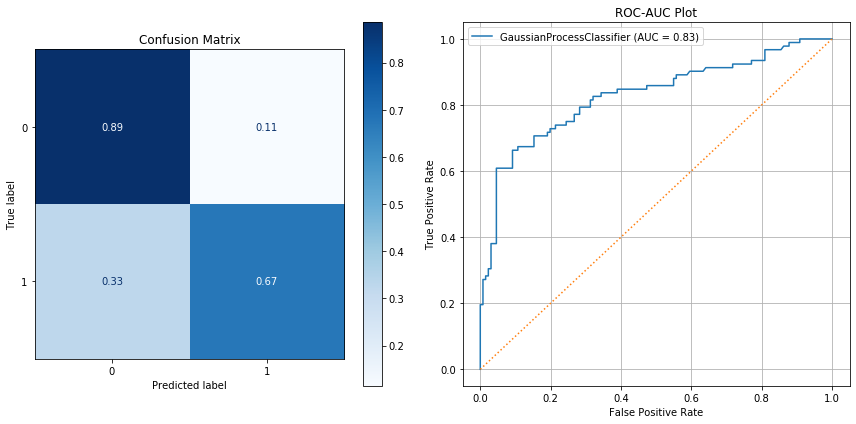

In [55]:
# Base model
gpc = GaussianProcessClassifier()
gpc.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(gpc, X_test_df, y_test)

#### GridsearchCV

In [56]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_restarts_optimizer' : [0, 1, 2],
          'max_iter_predict' : [25, 50, 100, 200]
         }

gcp_grid = GridSearchCV(estimator = GaussianProcessClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

gcp_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(gcp_grid.best_estimator_.get_params())

{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 25, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       131
           1       0.81      0.67      0.73        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.79       223



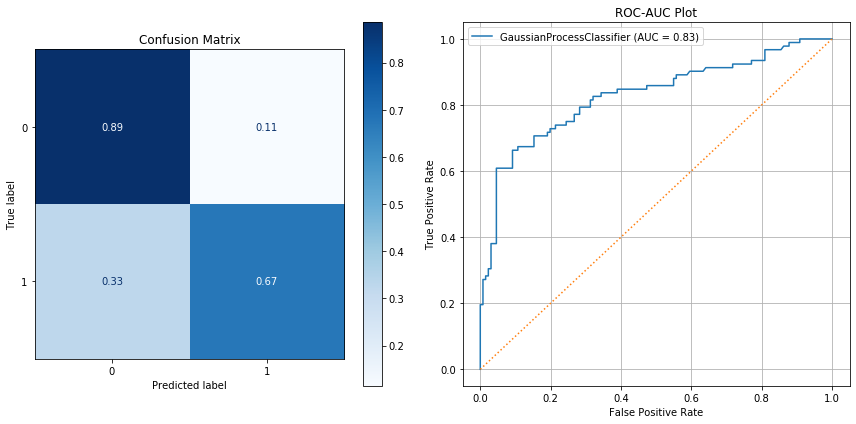

In [57]:
# Fit new model with the best hyperparameters

best_gcp_params = gcp_grid.best_params_
best_gcp_model = GaussianProcessClassifier(**best_gcp_params)
best_gcp_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_gcp_model, X_test_df, y_test)

### Naive Bayes

#### GaussianNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.26      0.39       131
           1       0.46      0.89      0.61        92

    accuracy                           0.52       223
   macro avg       0.62      0.58      0.50       223
weighted avg       0.64      0.52      0.48       223



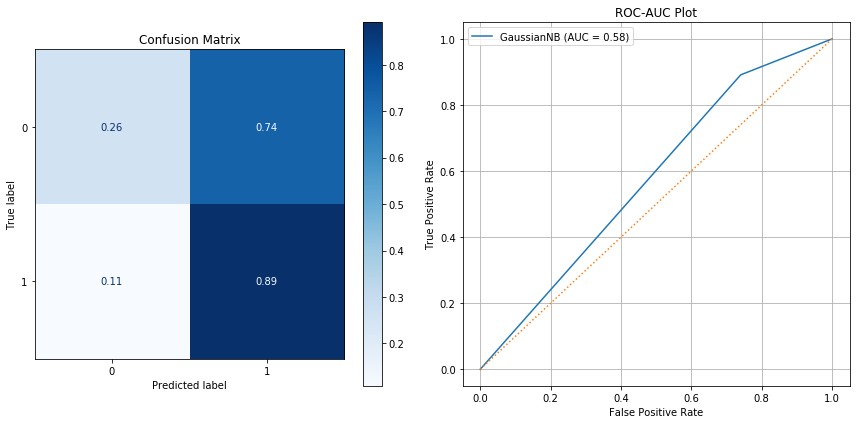

In [58]:
# Fitting a base random forest model

gaussiannb = GaussianNB()
gaussiannb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(gaussiannb, X_test_df, y_test)

#### BernoulliNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       131
           1       0.72      0.68      0.70        92

    accuracy                           0.76       223
   macro avg       0.75      0.75      0.75       223
weighted avg       0.76      0.76      0.76       223



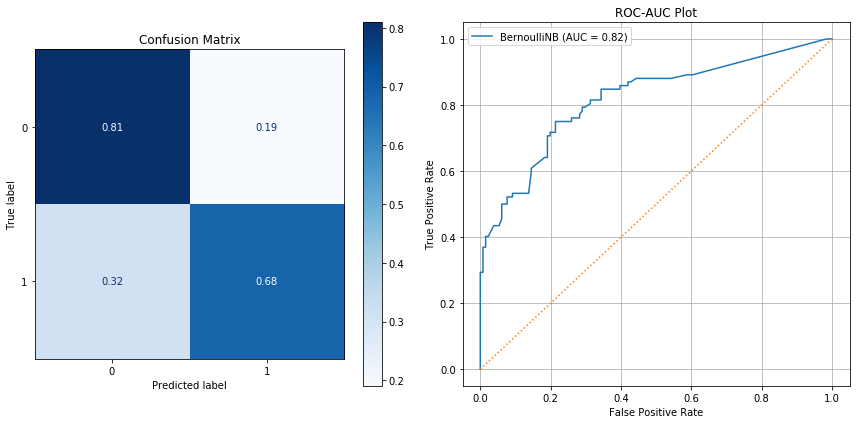

In [59]:
bernoullinb = BernoulliNB()
bernoullinb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(bernoullinb, X_test_df, y_test)

#### ComplementNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       131
           1       0.71      0.67      0.69        92

    accuracy                           0.75       223
   macro avg       0.75      0.74      0.74       223
weighted avg       0.75      0.75      0.75       223



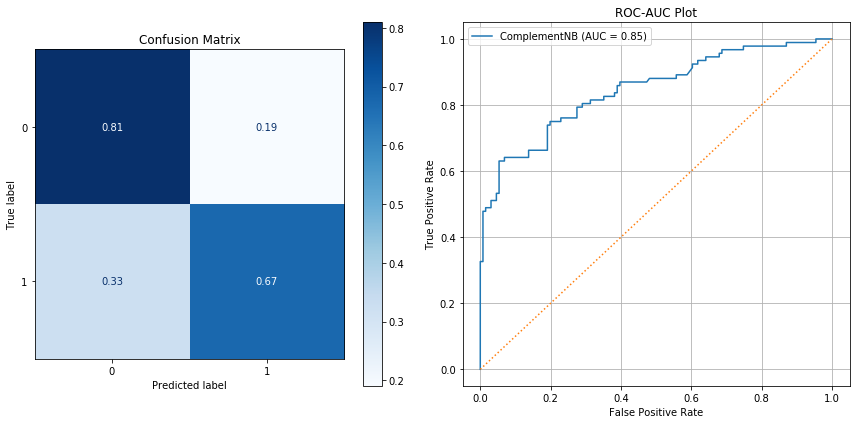

In [60]:
complementnb = ComplementNB()
complementnb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(complementnb, X_test_df, y_test)

#### MultinomialNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       131
           1       0.73      0.66      0.70        92

    accuracy                           0.76       223
   macro avg       0.76      0.75      0.75       223
weighted avg       0.76      0.76      0.76       223



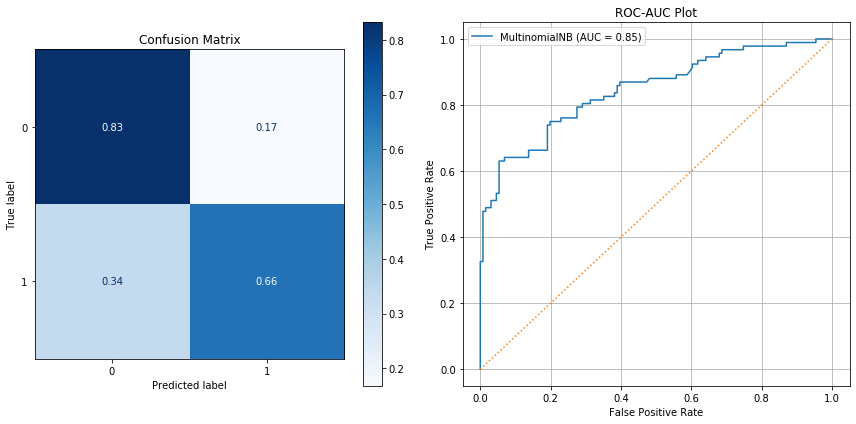

In [61]:
multinomialnb = MultinomialNB()
multinomialnb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(multinomialnb, X_test_df, y_test)

### Suppor Vector Machine

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       131
           1       0.76      0.71      0.73        92

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.78       223
weighted avg       0.78      0.78      0.78       223



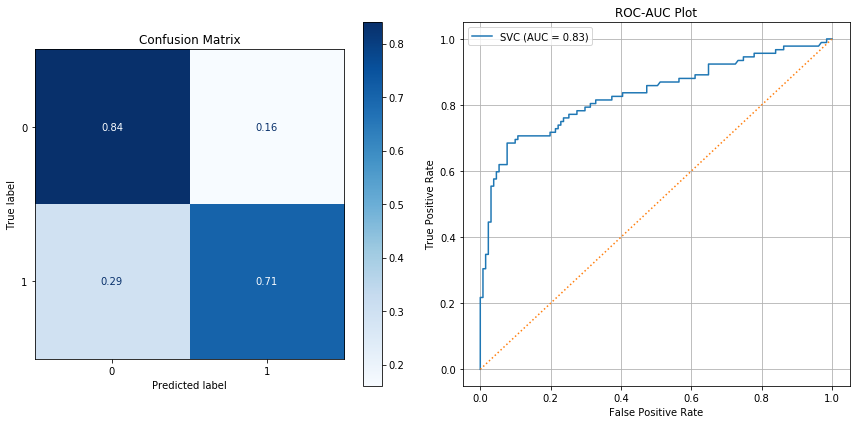

In [62]:
svc = SVC(class_weight = 'balanced')
svc.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(svc, X_test_df, y_test)

#### GridsearchCV

In [63]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced'],
          'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto'],
          'decision_function_shape' : ['ovo', 'ovr'],
          'C' : [0.1, 1, 10, 100, 1000],
         }

svc_grid = GridSearchCV(estimator = SVC(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

svc_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(svc_grid.best_estimator_.get_params())

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.84       131
           1       0.81      0.70      0.75        92

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.80       223



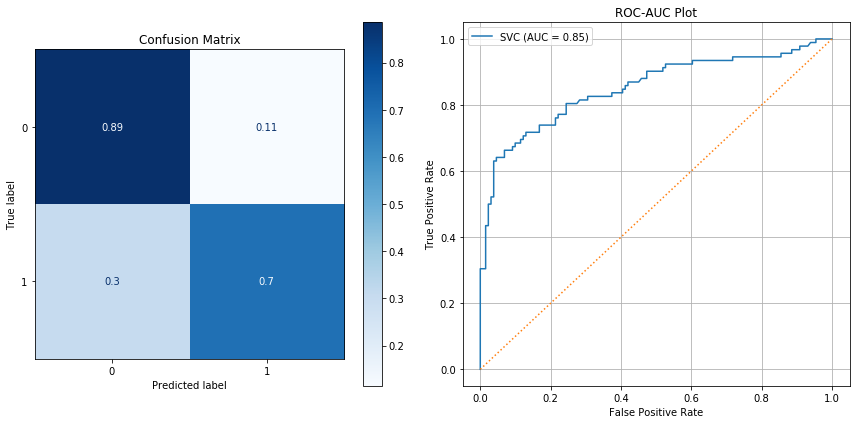

In [64]:
# Fit new model with the best hyperparameters

best_svc_params = svc_grid.best_params_
best_svc_model = SVC(**best_svc_params)
best_svc_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_svc_model, X_test_df, y_test)

### AdaBoost

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       131
           1       0.80      0.68      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



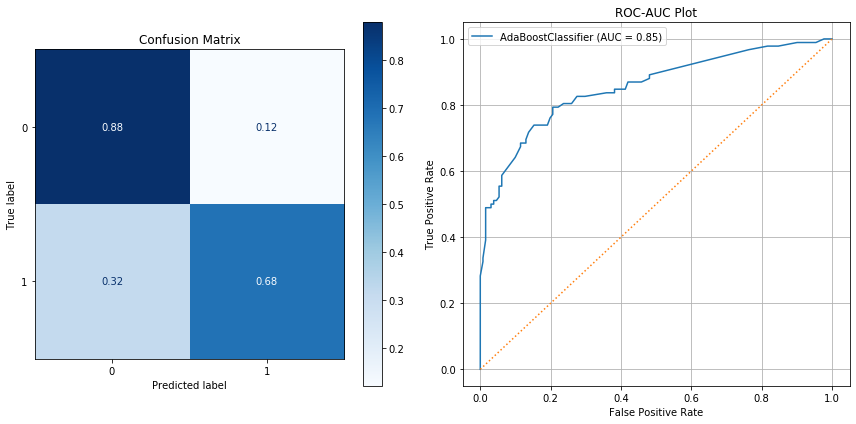

In [65]:
# Fitting a base random forest model

adaboost = AdaBoostClassifier()
adaboost.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(adaboost, X_test_df, y_test)

#### GridsearchCV

In [66]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_estimators' : [10, 100, 250, 500]}

ada_grid = GridSearchCV(estimator = AdaBoostClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

ada_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(ada_grid.best_estimator_.get_params())

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.84       131
           1       0.81      0.70      0.75        92

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.80       223



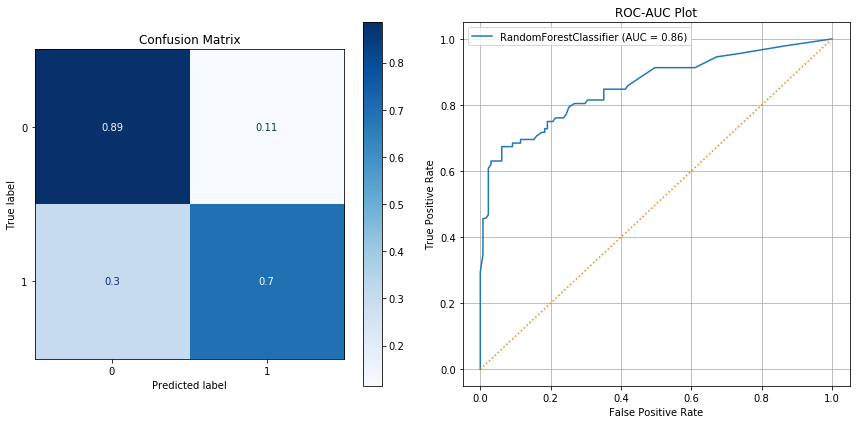

In [67]:
# Fit new model with the best hyperparameters

best_ada_params = ada_grid.best_params_
best_ada_model = RandomForestClassifier(**best_ada_params)
best_ada_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_ada_model, X_test_df, y_test)

### Random Forest

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.84       131
           1       0.81      0.70      0.75        92

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.80       223



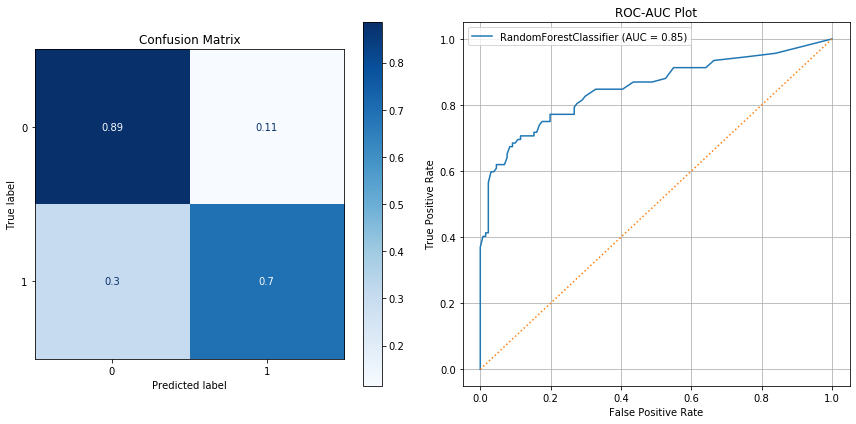

In [68]:
# Fitting a base random forest model

random_forest = RandomForestClassifier(class_weight = 'balanced')
random_forest.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(random_forest, X_test_df, y_test)

#### GridsearchCV

In [69]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced', 'balanced_subsample'],
          'n_estimators' : [10, 100, 250, 500],
          'criterion': ['gini', 'entropy'],
          'max_depth' : [1, 5, 10, 25], 
          'min_samples_split' : [2, 5, 10],
          'min_samples_leaf' : [1, 5, 10]}

rf_grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

rf_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(rf_grid.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       131
           1       0.78      0.71      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



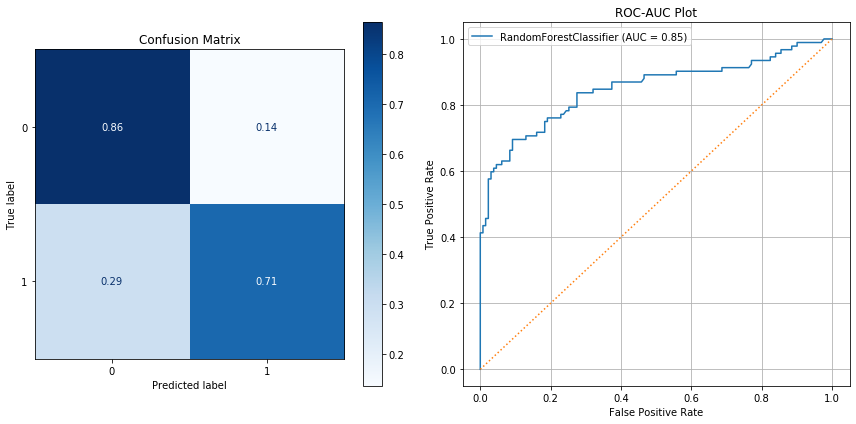

In [70]:
# Fit new model with the best hyperparameters

best_rf_params = rf_grid.best_params_
best_rf_model = RandomForestClassifier(**best_rf_params)
best_rf_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_rf_model, X_test_df, y_test)

### XGBoost

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       131
           1       0.83      0.71      0.76        92

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



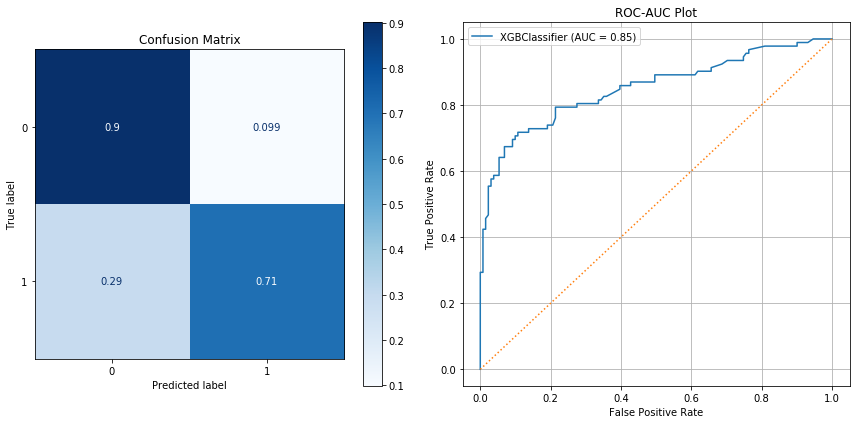

In [71]:
# Fitting a base xgboost model

xgboost = xgb.XGBClassifier()
xgboost.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(xgboost, X_test_df, y_test)

#### GridsearchCV

In [72]:
# Let's gridsearch this thing

params = {'booster': ['gbtree', 'gblinear', 'dart'],
          'gamma': [0, 0.5, 1, 2, 5],
          'max_delta_step': [0, 1, 2, 5],
          'max_depth' : [1, 5, 10, 25],
          'n_estimators': [10, 50, 100, 200]}

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(),
                        param_grid = params, 
                        cv = 3, 
                        n_jobs = -1)

xgb_grid.fit(X_train_df, y_train)

# Check out the best parameters
print(xgb_grid.best_estimator_.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 25, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       131
           1       0.86      0.71      0.77        92

    accuracy                           0.83       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



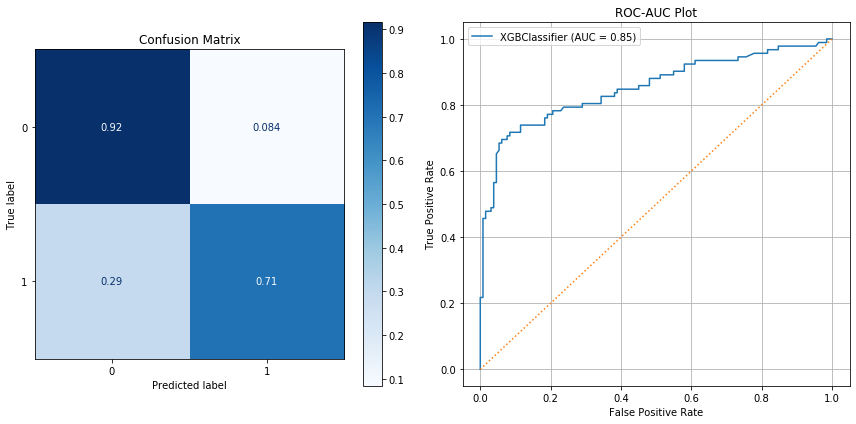

In [73]:
# Fit the model with the best parameters

best_xgb_params = xgb_grid.best_params_
best_xgb_model = xgb.XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(best_xgb_model, X_test_df, y_test)

### Stacking Classifier

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       131
           1       0.84      0.71      0.77        92

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.81       223
weighted avg       0.83      0.83      0.82       223



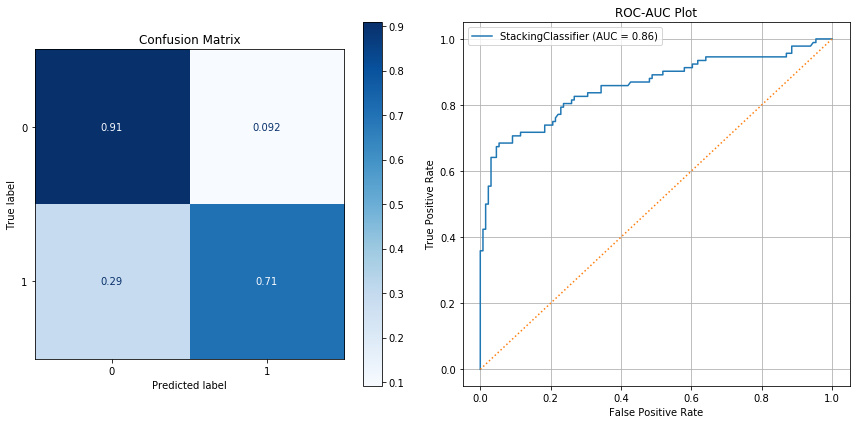

In [74]:
# Set up the stack

# Estimators made up of best performing models

estimators = [('mlp', best_mlp_model),
              ('ada', best_ada_model),
              ('rf', random_forest),
              ('svc', best_svc_model),
              ('xgb', best_xgb_model)]


# Fit the model

stack = StackingClassifier(estimators = estimators, 
                           final_estimator = LogisticRegression(),
                           cv = 5,
                           n_jobs = -1)

stack.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(stack, X_test_df, y_test)

### Voting Classifier

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       131
           1       0.84      0.71      0.77        92

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.81       223
weighted avg       0.83      0.83      0.82       223



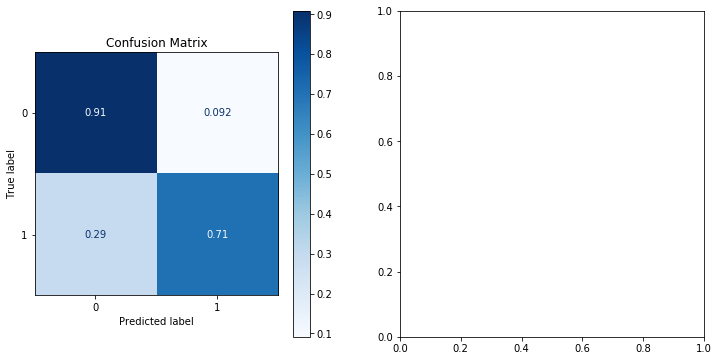

In [75]:
from sklearn.ensemble import VotingClassifier

# Estimators made up of best performing models

estimators = [('mlp', best_mlp_model),
              ('ada', best_ada_model),
              ('rf', random_forest),
              ('svc', best_svc_model),
              ('xgb', best_xgb_model)]


# Fit the model

vote = VotingClassifier(estimators = estimators, 
                           n_jobs = -1)

vote.fit(X_train_df, y_train)

# Evaluate Model

evaluate_voting_model(vote, X_test_df, y_test)

### Deep Neural Network

#### Base Model

W0127 11:54:00.170263 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


Epoch 1/100


W0127 11:54:00.410038 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


 1/30 [>.............................] - ETA: 0s - loss: 0.6967 - accuracy: 0.4375

W0127 11:54:01.180625 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


30/30 [==============================] - 1s 19ms/step - loss: 0.6912 - accuracy: 0.6188 - val_loss: 0.6896 - val_accuracy: 0.6169
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.6552 - val_loss: 0.6646 - val_accuracy: 0.6169
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6638 - val_loss: 0.6002 - val_accuracy: 0.6716
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5856 - accuracy: 0.7388 - val_loss: 0.5136 - val_accuracy: 0.8209
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5079 - accuracy: 0.7345 - val_loss: 0.4572 - val_accuracy: 0.8209
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5130 - accuracy: 0.7602 - val_loss: 0.4595 - val_accuracy: 0.8209
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4784 - accuracy: 0.8116 - val_loss: 0.4103 - val_accuracy: 0.8507
Epoch 8/100
30/30 [=====

W0127 11:54:02.832877 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


                 Model Evaluation
-------------------------------------------------------
7/7 [==============================] - 0s 1ms/step - loss: 0.4600 - accuracy: 0.7937
[0.4600483477115631, 0.7937219738960266]
 
                 Loss & Accuracy Curves
-------------------------------------------------------


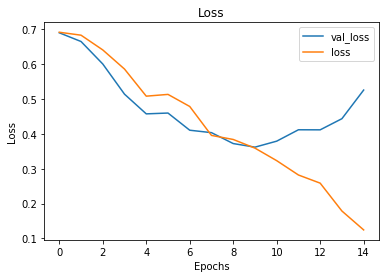

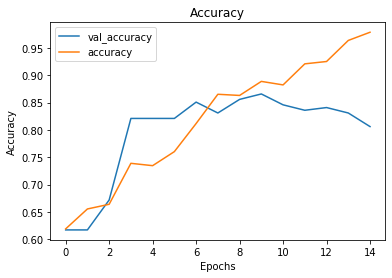

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       131
           1       0.77      0.72      0.74        92

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223

 
                 Confusion Matrix
-------------------------------------------------------


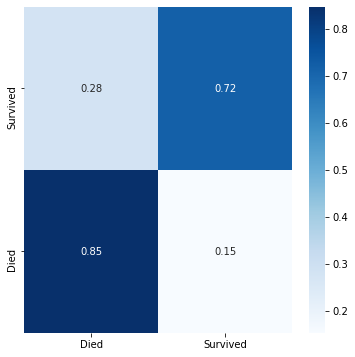

In [76]:
# Model Architecture

# Early Stopping
callback = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max',
                         min_delta = 0.01, restore_best_weights = True)

# Create base model
model = Sequential()

# Input layer
model.add(Dense(128, input_shape = X_train_df.shape, activation = 'relu'))

# Hidden layers
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile 
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 16, epochs = 100,
                    validation_split = 0.3, callbacks = callback, workers = 16)

# Evaluate the model
evaluate_network(history, model, X_test_df, y_test)

#### Model with Adjusted Class Weights

In [44]:
from sklearn.utils import class_weight

In [45]:
np.unique(y_train)

array([0, 1])

In [46]:
class_weights = dict(zip(np.unique(y_train),class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)))

W0128 23:14:42.703545 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_10_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


Epoch 1/50


W0128 23:14:43.026306 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_10_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


20/34 [================>.............] - ETA: 0s - loss: 0.6138 - accuracy: 0.7344

W0128 23:14:44.080739 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_10_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


34/34 [==============================] - 1s 21ms/step - loss: 0.5860 - accuracy: 0.7640 - val_loss: 0.5081 - val_accuracy: 0.8060
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.5110 - accuracy: 0.8052 - val_loss: 0.4953 - val_accuracy: 0.8134
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.4983 - accuracy: 0.8071 - val_loss: 0.4860 - val_accuracy: 0.8134
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.4927 - accuracy: 0.8146 - val_loss: 0.4816 - val_accuracy: 0.8134
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.4889 - accuracy: 0.8221 - val_loss: 0.4741 - val_accuracy: 0.8134
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.4737 - accuracy: 0.8240 - val_loss: 0.4794 - val_accuracy: 0.8134
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 0.4647 - accuracy: 0.8202 - val_loss: 0.4744 - val_accuracy: 0.8134
Epoch 8/50
34/34 [============

W0128 23:14:50.910621 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_10_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


                 Model Evaluation
-------------------------------------------------------
7/7 [==============================] - 0s 2ms/step - loss: 0.5332 - accuracy: 0.7937
[0.5331689715385437, 0.7937219738960266]
 
                 Loss & Accuracy Curves
-------------------------------------------------------


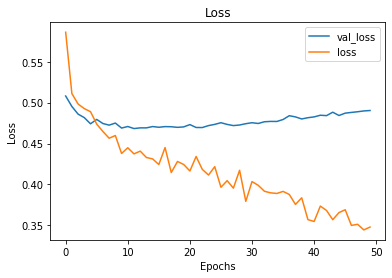

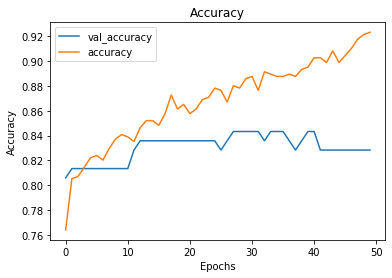

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       131
           1       0.77      0.71      0.74        92

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223

 
                 Confusion Matrix
-------------------------------------------------------


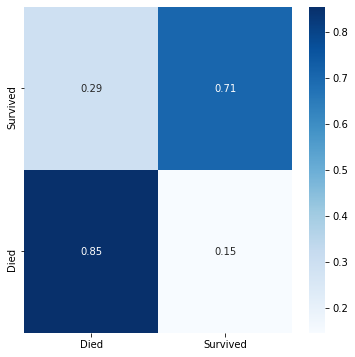

In [47]:
# Model Architecture

# Early Stopping
callback = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max',
                         min_delta = 0.01, restore_best_weights = True)

# Create base model
model = Sequential()

# Input layer
model.add(Dense(256, input_shape = X_train_df.shape, activation = 'tanh', 
                kernel_initializer = 'constant', kernel_regularizer = tf.keras.regularizers.L1(0.001),
                activity_regularizer = tf.keras.regularizers.L2(0.001)))

# Hidden layers
model.add(Dense(128, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'selu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile 
model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 16, epochs = 50,
                    validation_split = 0.2, class_weight = class_weights, 
                    workers = 16)#, callbacks = callback)

# Evaluate the model
evaluate_network(history, model, X_test_df, y_test)

#### Tester with giant model

W0128 23:20:50.423729 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_136_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


Epoch 1/50


W0128 23:20:50.797368 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_136_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


65/67 [============================>.] - ETA: 0s - loss: 0.8076 - accuracy: 0.6346

W0128 23:20:51.844828 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_136_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


67/67 [==============================] - 1s 11ms/step - loss: 0.8022 - accuracy: 0.6348 - val_loss: 0.6119 - val_accuracy: 0.7985
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 0.7756 - accuracy: 0.6667 - val_loss: 0.6075 - val_accuracy: 0.7910
Epoch 3/50
67/67 [==============================] - 0s 3ms/step - loss: 0.7276 - accuracy: 0.6910 - val_loss: 0.5850 - val_accuracy: 0.8134
Epoch 4/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.7079 - val_loss: 0.5811 - val_accuracy: 0.8134
Epoch 5/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.7360 - val_loss: 0.5625 - val_accuracy: 0.8284
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.7116 - val_loss: 0.5650 - val_accuracy: 0.8134
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.7434 - val_loss: 0.5601 - val_accuracy: 0.8284
Epoch 8/50
67/67 [============

W0128 23:21:01.631825 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_136_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


                 Model Evaluation
-------------------------------------------------------
7/7 [==============================] - 0s 2ms/step - loss: 0.6112 - accuracy: 0.7982
[0.6111883521080017, 0.7982062697410583]
 
                 Loss & Accuracy Curves
-------------------------------------------------------


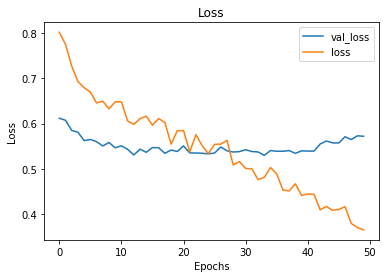

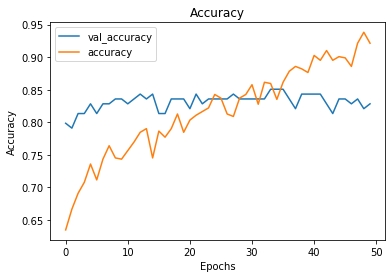

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       131
           1       0.79      0.70      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223

 
                 Confusion Matrix
-------------------------------------------------------


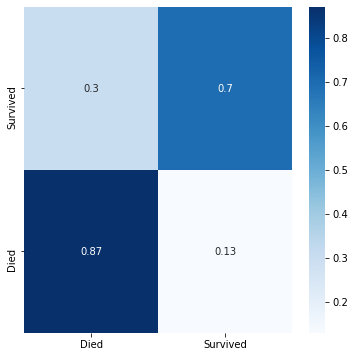

In [60]:
# Model Architecture

# Early Stopping
callback = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max',
                         min_delta = 0.01, restore_best_weights = True)

# Create base model
model = Sequential()

# Input layer
model.add(Dense(128, input_shape = X_train_df.shape, activation = 'selu', 
                kernel_initializer = 'constant', kernel_regularizer = tf.keras.regularizers.L1(0.01),
                activity_regularizer = tf.keras.regularizers.L2(0.001)))

# Hidden layers
model.add(Dense(64, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = 'selu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile 
model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 8, epochs = 50,
                    validation_split = 0.2, class_weight = class_weights, 
                    workers = 16)#, callbacks = callback)

# Evaluate the model
evaluate_network(history, model, X_test_df, y_test)

## Interpret

### Feature Importances

In [81]:
features_dict = {'Features': X_train_df.columns,
                 'Importance': best_xgb_model.feature_importances_}

features_df = pd.DataFrame(features_dict, columns = ['Features', 'Importance'])

features_df.sort_values(by = 'Importance', ascending = False)

,Features,Importance
29,Title_ Mr,0.429300
32,Title_ Rev,0.124880
0,Pclass,0.079942
53,Last Name_Asplund,0.068151
22,Title_ Dr,0.047757
...,...,...
196,Last Name_Frolicher,0.000000
195,Last Name_Frauenthal,0.000000
194,Last Name_Francatelli,0.000000
193,Last Name_Fortune,0.000000


In [82]:
for i in features_df['Importance']:
    if i == 0:
        features_df['Importance'].replace(i, np.nan, inplace = True)
        
features_df.dropna(inplace = True)

features_df.sort_values(by = 'Importance', ascending = False)

,Features,Importance
29,Title_ Mr,0.429300
32,Title_ Rev,0.124880
0,Pclass,0.079942
53,Last Name_Asplund,0.068151
22,Title_ Dr,0.047757
5,Family Size,0.030847
15,Cabin Level_E,0.030082
6,Sex_female,0.025749
18,Cabin Level_M,0.018469
4,Fare,0.015332


In [83]:
import shap

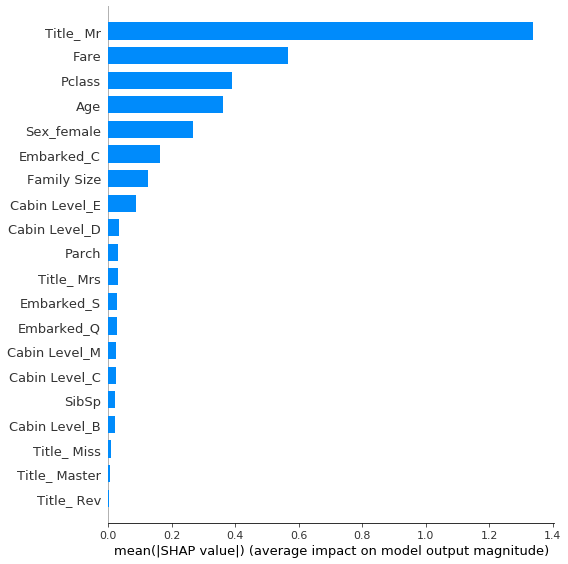

In [84]:
X_shap = shap.sample(X_test_df, 100)
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_shap)

# Plotting a summary plot
fig = shap.summary_plot(shap_values, X_shap, plot_type = 'bar')

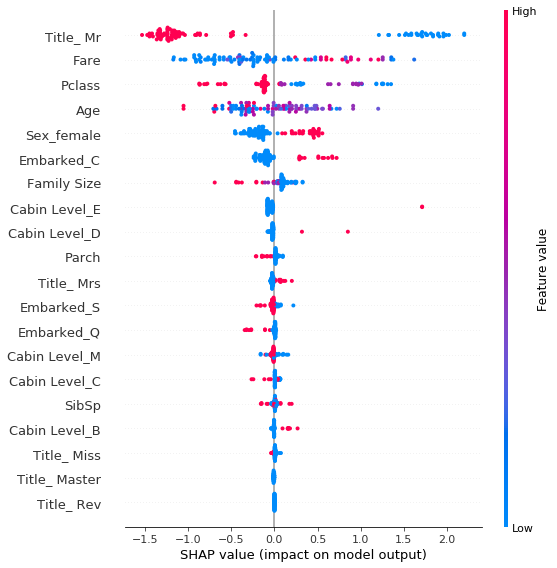

In [85]:
# The shap feature importances plot

shap.summary_plot(shap_values, X_shap)

## Test Data & Modeling

In [147]:
# Process the test data

test_processed = preprocessing(test_df, test_df['Name'])

test_processed.head()

,Pclass,Age,SibSp,Parch,Fare,Family Size,Sex_female,Sex_male,Cabin_A11,Cabin_A18,Cabin_A21,Cabin_A29,Cabin_A34,Cabin_A9,Cabin_B10,Cabin_B11,Cabin_B24,Cabin_B26,Cabin_B36,Cabin_B41,Cabin_B45,Cabin_B51 B53 B55,Cabin_B52 B54 B56,Cabin_B57 B59 B63 B66,Cabin_B58 B60,Cabin_B61,Cabin_B69,Cabin_B71,Cabin_B78,Cabin_C101,Cabin_C105,Cabin_C106,Cabin_C116,Cabin_C130,Cabin_C132,Cabin_C22 C26,Cabin_C23 C25 C27,Cabin_C28,Cabin_C31,Cabin_C32,Cabin_C39,Cabin_C46,Cabin_C51,Cabin_C53,Cabin_C54,Cabin_C55 C57,Cabin_C6,Cabin_C62 C64,Cabin_C7,Cabin_C78,Cabin_C80,Cabin_C85,Cabin_C86,Cabin_C89,Cabin_C97,Cabin_D,Cabin_D10 D12,Cabin_D15,Cabin_D19,Cabin_D21,Cabin_D22,Cabin_D28,Cabin_D30,Cabin_D34,Cabin_D37,Cabin_D38,Cabin_D40,Cabin_D43,Cabin_E31,Cabin_E34,Cabin_E39 E41,Cabin_E45,Cabin_E46,Cabin_E50,Cabin_E52,Cabin_E60,Cabin_F,Cabin_F E46,Cabin_F E57,Cabin_F G63,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_Missing,Embarked_C,Embarked_Q,Embarked_S,Cabin Level_A,Cabin Level_B,Cabin Level_C,Cabin Level_D,Cabin Level_E,Cabin Level_F,Cabin Level_G,Cabin Level_M,Title_ Col,Title_ Dona,Title_ Dr,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Last Name_Abbott,Last Name_Abelseth,Last Name_Abrahamsson,Last Name_Abrahim,Last Name_Aks,Last Name_Aldworth,Last Name_Allison,Last Name_Andersen,Last Name_Andersson,Last Name_Andrew,Last Name_Angheloff,Last Name_Angle,Last Name_Aronsson,Last Name_Ashby,Last Name_Asplund,Last Name_Assaf,Last Name_Assaf Khalil,Last Name_Assam,Last Name_Astor,Last Name_Baccos,Last Name_Badman,Last Name_Baimbrigge,Last Name_Barry,Last Name_Beattie,Last Name_Beauchamp,Last Name_Becker,Last Name_Bentham,Last Name_Betros,Last Name_Bird,Last Name_Birnbaum,Last Name_Bjorklund,Last Name_Bonnell,Last Name_Borebank,Last Name_Botsford,Last Name_Boulos,Last Name_Bowen,Last Name_Bowenur,Last Name_Bradley,Last Name_Brady,Last Name_Braf,Last Name_Brandeis,Last Name_Brobeck,Last Name_Brown,Last Name_Bryhl,Last Name_Buckley,Last Name_Bucknell,Last Name_Burns,Last Name_Cacic,Last Name_Caldwell,Last Name_Canavan,Last Name_Candee,Last Name_Caram,Last Name_Cardeza,Last Name_Carlsson,Last Name_Carr,Last Name_Carrau,Last Name_Carver,Last Name_Case,Last Name_Cassebeer,Last Name_Cavendish,Last Name_Chaffee,Last Name_Chapman,Last Name_Chaudanson,Last Name_Chevre,Last Name_Chisholm,Last Name_Christy,Last Name_Chronopoulos,Last Name_Clark,Last Name_Clarke,Last Name_Colbert,Last Name_Collett,Last Name_Compton,Last Name_Conlon,Last Name_Connolly,Last Name_Cook,Last Name_Cor,Last Name_Corbett,Last Name_Corey,Last Name_Cornell,Last Name_Cotterill,Last Name_Coutts,Last Name_Crafton,Last Name_Cribb,Last Name_Crosby,Last Name_Cumings,Last Name_Daher,Last Name_Daly,Last Name_Danbom,Last Name_Daniels,Last Name_Davidson,Last Name_Davies,Last Name_Davison,Last Name_Deacon,Last Name_Dean,Last Name_Delalic,Last Name_Demetri,Last Name_Denbury,Last Name_Dennis,Last Name_Dibden,Last Name_Dika,Last Name_Dintcheff,Last Name_Dodge,Last Name_Douglas,Last Name_Doyle,Last Name_Drapkin,Last Name_Drew,Last Name_Dulles,Last Name_Duquemin,Last Name_Duran y More,Last Name_Dyker,Last Name_Earnshaw,Last Name_Elias,Last Name_Enander,Last Name_Evans,Last Name_Everett,Last Name_Faunthorpe,Last Name_Fillbrook,Last Name_Finoli,Last Name_Flegenheim,Last Name_Fleming,Last Name_Foley,Last Name_Ford,Last Name_Fortune,Last Name_Fox,Last Name_Franklin,Last Name_Frauenthal,Last Name_Frolicher-Stehli,Last Name_Gale,Last Name_Geiger,Last Name_Gibson,Last Name_Gilbert,Last Name_Giles,Last Name_Goldsmith,Last Name_Goodwin,Last Name_Gracie,Last Name_Greenfield,Last Name_Guest,Last Name_Hagardon,Last Name_Hansen,Last Name_Harbeck,Last Name_Harder,Last Name_Hays,Last Name_Head,Last Name_Hee,Last Name_Hellstrom,Last Name_Henriksson,Last Name_Herman,Last Name_Hilliard,Last Name_Hiltunen,Last Name_Hipkins,Last Name_Hirvonen,Last Name_Hocking,Last Name_Hold,Last Name_Holthen,Last Name_Howard,Last Name_Hyman,Last Name_Ilieff,Last Name_Ilmakangas,Last Name_Ismay,Last Name_Jefferys,Last Name_Johansson,Las

In [148]:
# Evaluate the model with the test data

predictions = best_xgb_model.predict(test_processed)

predictions

ValueError: feature_names mismatch: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family Size', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin Level_A', 'Cabin Level_B', 'Cabin Level_C', 'Cabin Level_D', 'Cabin Level_E', 'Cabin Level_F', 'Cabin Level_G', 'Cabin Level_M', 'Cabin Level_T', 'Title_ Col', 'Title_ Don', 'Title_ Dr', 'Title_ Lady', 'Title_ Major', 'Title_ Master', 'Title_ Miss', 'Title_ Mlle', 'Title_ Mme', 'Title_ Mr', 'Title_ Mrs', 'Title_ Ms', 'Title_ Rev', 'Title_ Sir', 'Last Name_Abbing', 'Last Name_Abbott', 'Last Name_Abelson', 'Last Name_Adahl', 'Last Name_Adams', 'Last Name_Aks', 'Last Name_Albimona', 'Last Name_Alexander', 'Last Name_Ali', 'Last Name_Allen', 'Last Name_Allison', 'Last Name_Anderson', 'Last Name_Andersson', 'Last Name_Andreasson', 'Last Name_Andrew', 'Last Name_Angle', 'Last Name_Appleton', 'Last Name_Arnold-Franchi', 'Last Name_Asim', 'Last Name_Asplund', 'Last Name_Astor', 'Last Name_Attalah', 'Last Name_Aubart', 'Last Name_Augustsson', 'Last Name_Ayoub', 'Last Name_Backstrom', 'Last Name_Baclini', 'Last Name_Badt', 'Last Name_Balkic', 'Last Name_Ball', 'Last Name_Banfield', 'Last Name_Barah', 'Last Name_Barbara', 'Last Name_Bateman', 'Last Name_Baumann', 'Last Name_Baxter', 'Last Name_Bazzani', 'Last Name_Beane', 'Last Name_Beavan', 'Last Name_Becker', 'Last Name_Beckwith', 'Last Name_Behr', 'Last Name_Bengtsson', 'Last Name_Berglund', 'Last Name_Betros', 'Last Name_Bidois', 'Last Name_Birkeland', 'Last Name_Bishop', 'Last Name_Bissette', 'Last Name_Bjornstrom-Steffansson', 'Last Name_Blackwell', 'Last Name_Bonnell', 'Last Name_Boulos', 'Last Name_Bourke', 'Last Name_Bowen', 'Last Name_Bowerman', 'Last Name_Bracken', 'Last Name_Bradley', 'Last Name_Braund', 'Last Name_Brewe', 'Last Name_Brocklebank', 'Last Name_Brown', 'Last Name_Burke', 'Last Name_Burns', 'Last Name_Butler', 'Last Name_Butt', 'Last Name_Byles', 'Last Name_Bystrom', 'Last Name_Cacic', 'Last Name_Cairns', 'Last Name_Calderhead', 'Last Name_Caldwell', 'Last Name_Calic', 'Last Name_Cameron', 'Last Name_Campbell', 'Last Name_Cann', 'Last Name_Carlsson', 'Last Name_Carr', 'Last Name_Carrau', 'Last Name_Carter', 'Last Name_Cavendish', 'Last Name_Celotti', 'Last Name_Chaffee', 'Last Name_Chambers', 'Last Name_Chapman', 'Last Name_Charters', 'Last Name_Chibnall', 'Last Name_Chip', 'Last Name_Christmann', 'Last Name_Christy', 'Last Name_Chronopoulos', 'Last Name_Clarke', 'Last Name_Cleaver', 'Last Name_Clifford', 'Last Name_Coelho', 'Last Name_Cohen', 'Last Name_Coleff', 'Last Name_Coleridge', 'Last Name_Collander', 'Last Name_Colley', 'Last Name_Collyer', 'Last Name_Compton', 'Last Name_Connolly', 'Last Name_Connors', 'Last Name_Cook', 'Last Name_Cor', 'Last Name_Coutts', 'Last Name_Coxon', 'Last Name_Crease', 'Last Name_Cribb', 'Last Name_Crosby', 'Last Name_Culumovic', 'Last Name_Cumings', 'Last Name_Dahlberg', 'Last Name_Dakic', 'Last Name_Daly', 'Last Name_Danbom', 'Last Name_Daniel', 'Last Name_Danoff', 'Last Name_Dantcheff', 'Last Name_Davies', 'Last Name_Davis', 'Last Name_Davison', 'Last Name_Dean', 'Last Name_Denkoff', 'Last Name_Dennis', 'Last Name_Devaney', 'Last Name_Dick', 'Last Name_Dimic', 'Last Name_Dodge', 'Last Name_Doharr', 'Last Name_Doling', 'Last Name_Dorking', 'Last Name_Dowdell', 'Last Name_Downton', 'Last Name_Drazenoic', 'Last Name_Drew', 'Last Name_Duane', 'Last Name_Duff Gordon', 'Last Name_Duran y More', 'Last Name_Edvardsson', 'Last Name_Eitemiller', 'Last Name_Eklund', 'Last Name_Ekstrom', 'Last Name_Elias', 'Last Name_Elsbury', 'Last Name_Emanuel', 'Last Name_Emir', 'Last Name_Endres', 'Last Name_Eustis', 'Last Name_Fahlstrom', 'Last Name_Farrell', 'Last Name_Farthing', 'Last Name_Fischer', 'Last Name_Fleming', 'Last Name_Flynn', 'Last Name_Foo', 'Last Name_Ford', 'Last Name_Foreman', 'Last Name_Fortune', 'Last Name_Francatelli', 'Last Name_Frauenthal', 'Last Name_Frolicher', 'Last Name_Frost', 'Last Name_Funk', 'Last Name_Fynney', 'Last Name_Gaskell', 'Last Name_Gavey', 'Last Name_Gee', 'Last Name_Gheorgheff', 'Last Name_Giglio', 'Last Name_Giles', 'Last Name_Gill', 'Last Name_Gillespie', 'Last Name_Gilnagh', 'Last Name_Givard', 'Last Name_Glynn', 'Last Name_Goldenberg', 'Last Name_Goldschmidt', 'Last Name_Goldsmith', 'Last Name_Goncalves', 'Last Name_Goodwin', 'Last Name_Graham', 'Last Name_Greenberg', 'Last Name_Greenfield', 'Last Name_Guggenheim', 'Last Name_Gustafsson', 'Last Name_Haas', 'Last Name_Hagland', 'Last Name_Hakkarainen', 'Last Name_Hale', 'Last Name_Hamalainen', 'Last Name_Hampe', 'Last Name_Hanna', 'Last Name_Hansen', 'Last Name_Harder', 'Last Name_Harknett', 'Last Name_Harmer', 'Last Name_Harper', 'Last Name_Harrington', 'Last Name_Harris', 'Last Name_Harrison', 'Last Name_Hart', 'Last Name_Hassab', 'Last Name_Hassan', 'Last Name_Hawksford', 'Last Name_Hays', 'Last Name_Hedman', 'Last Name_Hegarty', 'Last Name_Heikkinen', 'Last Name_Heininen', 'Last Name_Hendekovic', 'Last Name_Henry', 'Last Name_Herman', 'Last Name_Hewlett', 'Last Name_Hickman', 'Last Name_Hippach', 'Last Name_Hocking', 'Last Name_Hodges', 'Last Name_Hogeboom', 'Last Name_Holm', 'Last Name_Holverson', 'Last Name_Homer', 'Last Name_Honkanen', 'Last Name_Hood', 'Last Name_Horgan', 'Last Name_Hosono', 'Last Name_Hoyt', 'Last Name_Hunt', 'Last Name_Ibrahim Shawah', 'Last Name_Ilett', 'Last Name_Ilmakangas', 'Last Name_Isham', 'Last Name_Ivanoff', 'Last Name_Jacobsohn', 'Last Name_Jalsevac', 'Last Name_Jardin', 'Last Name_Jarvis', 'Last Name_Jenkin', 'Last Name_Jensen', 'Last Name_Jerwan', 'Last Name_Johannesen-Bratthammer', 'Last Name_Johanson', 'Last Name_Johansson', 'Last Name_Johnson', 'Last Name_Johnston', 'Last Name_Jonkoff', 'Last Name_Jonsson', 'Last Name_Jussila', 'Last Name_Kallio', 'Last Name_Kalvik', 'Last Name_Kantor', 'Last Name_Karaic', 'Last Name_Karlsson', 'Last Name_Kassem', 'Last Name_Keane', 'Last Name_Kelly', 'Last Name_Kent', 'Last Name_Kiernan', 'Last Name_Kilgannon', 'Last Name_Kimball', 'Last Name_Klaber', 'Last Name_Klasen', 'Last Name_Knight', 'Last Name_Kraeff', 'Last Name_Lahoud', 'Last Name_Lahtinen', 'Last Name_Landergren', 'Last Name_Lang', 'Last Name_Laroche', 'Last Name_Larsson', 'Last Name_LeRoy', 'Last Name_Leader', 'Last Name_Lefebre', 'Last Name_Leitch', 'Last Name_Lemberopolous', 'Last Name_Lemore', 'Last Name_Lennon', 'Last Name_Leonard', 'Last Name_Lester', 'Last Name_Lesurer', 'Last Name_Levy', 'Last Name_Lewy', 'Last Name_Leyson', 'Last Name_Lievens', 'Last Name_Lindahl', 'Last Name_Lindblom', 'Last Name_Lindell', 'Last Name_Lindqvist', 'Last Name_Lines', 'Last Name_Ling', 'Last Name_Lobb', 'Last Name_Long', 'Last Name_Lovell', 'Last Name_Lulic', 'Last Name_Lundahl', 'Last Name_Lurette', 'Last Name_Mack', 'Last Name_Madigan', 'Last Name_Madill', 'Last Name_Maenpaa', 'Last Name_Maioni', 'Last Name_Maisner', 'Last Name_Mallet', 'Last Name_Mamee', 'Last Name_Mangan', 'Last Name_Mannion', 'Last Name_Marechal', 'Last Name_Markoff', 'Last Name_Markun', 'Last Name_Marvin', 'Last Name_Masselmani', 'Last Name_Matthews', 'Last Name_McCarthy', 'Last Name_McDermott', 'Last Name_McEvoy', 'Last Name_McGovern', 'Last Name_McGowan', 'Last Name_McKane', 'Last Name_McMahon', 'Last Name_McNamee', 'Last Name_Meanwell', 'Last Name_Meek', 'Last Name_Mellinger', 'Last Name_Meyer', 'Last Name_Milling', 'Last Name_Minahan', 'Last Name_Mineff', 'Last Name_Mionoff', 'Last Name_Mitchell', 'Last Name_Mitkoff', 'Last Name_Moen', 'Last Name_Moor', 'Last Name_Moore', 'Last Name_Moran', 'Last Name_Moraweck', 'Last Name_Morrow', 'Last Name_Moubarek', 'Last Name_Moussa', 'Last Name_Moutal', 'Last Name_Mullens', 'Last Name_Murdlin', 'Last Name_Murphy', 'Last Name_Myhrman', 'Last Name_Naidenoff', 'Last Name_Najib', 'Last Name_Nankoff', 'Last Name_Nasser', 'Last Name_Navratil', 'Last Name_Nenkoff', 'Last Name_Newell', 'Last Name_Newsom', 'Last Name_Nicholls', 'Last Name_Nicholson', 'Last Name_Nicola-Yarred', 'Last Name_Nilsson', 'Last Name_Niskanen', 'Last Name_Norman', 'Last Name_Nosworthy', 'Last Name_Nye', 'Last Name_Nysten', 'Last Name_Nysveen', "Last Name_O'Brien", "Last Name_O'Connor", "Last Name_O'Dwyer", "Last Name_O'Sullivan", 'Last Name_Odahl', 'Last Name_Ohman', 'Last Name_Olsen', 'Last Name_Olsvigen', 'Last Name_Oreskovic', 'Last Name_Osen', 'Last Name_Osman', 'Last Name_Ostby', 'Last Name_Otter', 'Last Name_Padro y Manent', 'Last Name_Pain', 'Last Name_Palsson', 'Last Name_Panula', 'Last Name_Parkes', 'Last Name_Parr', 'Last Name_Parrish', 'Last Name_Partner', 'Last Name_Pasic', 'Last Name_Patchett', 'Last Name_Paulner', 'Last Name_Pavlovic', 'Last Name_Pears', 'Last Name_Peduzzi', 'Last Name_Pekoniemi', 'Last Name_Pernot', 'Last Name_Persson', 'Last Name_Peter', 'Last Name_Peters', 'Last Name_Petroff', 'Last Name_Pettersson', 'Last Name_Peuchen', 'Last Name_Phillips', 'Last Name_Pickard', 'Last Name_Ponesell', 'Last Name_Porter', 'Last Name_Potter', 'Last Name_Quick', 'Last Name_Radeff', 'Last Name_Razi', 'Last Name_Reeves', 'Last Name_Rekic', 'Last Name_Renouf', 'Last Name_Reynaldo', 'Last Name_Rice', 'Last Name_Richard', 'Last Name_Richards', 'Last Name_Ridsdale', 'Last Name_Risien', 'Last Name_Robbins', 'Last Name_Robert', 'Last Name_Roebling', 'Last Name_Rogers', 'Last Name_Romaine', 'Last Name_Rommetvedt', 'Last Name_Rood', 'Last Name_Rosblom', 'Last Name_Ross', 'Last Name_Rothschild', 'Last Name_Rush', 'Last Name_Ryerson', 'Last Name_Saad', 'Last Name_Saalfeld', 'Last Name_Sadlier', 'Last Name_Sage', 'Last Name_Sagesser', 'Last Name_Salkjelsvik', 'Last Name_Salonen', 'Last Name_Samaan', 'Last Name_Sandstrom', 'Last Name_Sawyer', 'Last Name_Scanlan', 'Last Name_Sdycoff', 'Last Name_Sedgwick', 'Last Name_Serepeca', 'Last Name_Seward', 'Last Name_Sharp', 'Last Name_Sheerlinck', 'Last Name_Shelley', 'Last Name_Shorney', 'Last Name_Shutes', 'Last Name_Silverthorne', 'Last Name_Simonius-Blumer', 'Last Name_Sinkkonen', 'Last Name_Sirayanian', 'Last Name_Sirota', 'Last Name_Sivic', 'Last Name_Sivola', 'Last Name_Sjoblom', 'Last Name_Sjostedt', 'Last Name_Skoog', 'Last Name_Slemen', 'Last Name_Smart', 'Last Name_Smith', 'Last Name_Sobey', 'Last Name_Soholt', 'Last Name_Somerton', 'Last Name_Spedden', 'Last Name_Stahelin-Maeglin', 'Last Name_Stankovic', 'Last Name_Stanley', 'Last Name_Stead', 'Last Name_Stewart', 'Last Name_Stone', 'Last Name_Stoytcheff', 'Last Name_Strom', 'Last Name_Sundman', 'Last Name_Sutton', 'Last Name_Swift', 'Last Name_Taussig', 'Last Name_Taylor', 'Last Name_Thayer', 'Last Name_Theobald', 'Last Name_Thomas', 'Last Name_Thorne', 'Last Name_Thorneycroft', 'Last Name_Tikkanen', 'Last Name_Tobin', 'Last Name_Todoroff', 'Last Name_Tomlin', 'Last Name_Toomey', 'Last Name_Torber', 'Last Name_Tornquist', 'Last Name_Toufik', 'Last Name_Touma', 'Last Name_Troupiansky', 'Last Name_Trout', 'Last Name_Troutt', 'Last Name_Turcin', 'Last Name_Turja', 'Last Name_Turkula', 'Last Name_Turpin', 'Last Name_Uruchurtu', 'Last Name_Van Impe', 'Last Name_Van der hoef', 'Last Name_Vande Walle', 'Last Name_Vanden Steen', 'Last Name_Vander Cruyssen', 'Last Name_Vander Planke', 'Last Name_Vestrom', 'Last Name_Walker', 'Last Name_Ward', 'Last Name_Warren', 'Last Name_Watt', 'Last Name_Webber', 'Last Name_Wells', 'Last Name_West', 'Last Name_Wheadon', 'Last Name_White', 'Last Name_Wick', 'Last Name_Widegren', 'Last Name_Widener', 'Last Name_Wiklund', 'Last Name_Wilhelms', 'Last Name_Williams', 'Last Name_Windelov', 'Last Name_Wiseman', 'Last Name_Wright', 'Last Name_Yasbeck', 'Last Name_Young', 'Last Name_Youseff', 'Last Name_Yousif', 'Last Name_Zabour', 'Last Name_de Messemaeker', 'Last Name_de Mulder', 'Last Name_de Pelsmaeker', 'Last Name_del Carlo', 'Last Name_van Billiard', 'Last Name_van Melkebeke'] ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family Size', 'Sex_female', 'Sex_male', 'Cabin_A11', 'Cabin_A18', 'Cabin_A21', 'Cabin_A29', 'Cabin_A34', 'Cabin_A9', 'Cabin_B10', 'Cabin_B11', 'Cabin_B24', 'Cabin_B26', 'Cabin_B36', 'Cabin_B41', 'Cabin_B45', 'Cabin_B51 B53 B55', 'Cabin_B52 B54 B56', 'Cabin_B57 B59 B63 B66', 'Cabin_B58 B60', 'Cabin_B61', 'Cabin_B69', 'Cabin_B71', 'Cabin_B78', 'Cabin_C101', 'Cabin_C105', 'Cabin_C106', 'Cabin_C116', 'Cabin_C130', 'Cabin_C132', 'Cabin_C22 C26', 'Cabin_C23 C25 C27', 'Cabin_C28', 'Cabin_C31', 'Cabin_C32', 'Cabin_C39', 'Cabin_C46', 'Cabin_C51', 'Cabin_C53', 'Cabin_C54', 'Cabin_C55 C57', 'Cabin_C6', 'Cabin_C62 C64', 'Cabin_C7', 'Cabin_C78', 'Cabin_C80', 'Cabin_C85', 'Cabin_C86', 'Cabin_C89', 'Cabin_C97', 'Cabin_D', 'Cabin_D10 D12', 'Cabin_D15', 'Cabin_D19', 'Cabin_D21', 'Cabin_D22', 'Cabin_D28', 'Cabin_D30', 'Cabin_D34', 'Cabin_D37', 'Cabin_D38', 'Cabin_D40', 'Cabin_D43', 'Cabin_E31', 'Cabin_E34', 'Cabin_E39 E41', 'Cabin_E45', 'Cabin_E46', 'Cabin_E50', 'Cabin_E52', 'Cabin_E60', 'Cabin_F', 'Cabin_F E46', 'Cabin_F E57', 'Cabin_F G63', 'Cabin_F2', 'Cabin_F33', 'Cabin_F4', 'Cabin_G6', 'Cabin_Missing', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin Level_A', 'Cabin Level_B', 'Cabin Level_C', 'Cabin Level_D', 'Cabin Level_E', 'Cabin Level_F', 'Cabin Level_G', 'Cabin Level_M', 'Title_ Col', 'Title_ Dona', 'Title_ Dr', 'Title_ Master', 'Title_ Miss', 'Title_ Mr', 'Title_ Mrs', 'Title_ Ms', 'Title_ Rev', 'Last Name_Abbott', 'Last Name_Abelseth', 'Last Name_Abrahamsson', 'Last Name_Abrahim', 'Last Name_Aks', 'Last Name_Aldworth', 'Last Name_Allison', 'Last Name_Andersen', 'Last Name_Andersson', 'Last Name_Andrew', 'Last Name_Angheloff', 'Last Name_Angle', 'Last Name_Aronsson', 'Last Name_Ashby', 'Last Name_Asplund', 'Last Name_Assaf', 'Last Name_Assaf Khalil', 'Last Name_Assam', 'Last Name_Astor', 'Last Name_Baccos', 'Last Name_Badman', 'Last Name_Baimbrigge', 'Last Name_Barry', 'Last Name_Beattie', 'Last Name_Beauchamp', 'Last Name_Becker', 'Last Name_Bentham', 'Last Name_Betros', 'Last Name_Bird', 'Last Name_Birnbaum', 'Last Name_Bjorklund', 'Last Name_Bonnell', 'Last Name_Borebank', 'Last Name_Botsford', 'Last Name_Boulos', 'Last Name_Bowen', 'Last Name_Bowenur', 'Last Name_Bradley', 'Last Name_Brady', 'Last Name_Braf', 'Last Name_Brandeis', 'Last Name_Brobeck', 'Last Name_Brown', 'Last Name_Bryhl', 'Last Name_Buckley', 'Last Name_Bucknell', 'Last Name_Burns', 'Last Name_Cacic', 'Last Name_Caldwell', 'Last Name_Canavan', 'Last Name_Candee', 'Last Name_Caram', 'Last Name_Cardeza', 'Last Name_Carlsson', 'Last Name_Carr', 'Last Name_Carrau', 'Last Name_Carver', 'Last Name_Case', 'Last Name_Cassebeer', 'Last Name_Cavendish', 'Last Name_Chaffee', 'Last Name_Chapman', 'Last Name_Chaudanson', 'Last Name_Chevre', 'Last Name_Chisholm', 'Last Name_Christy', 'Last Name_Chronopoulos', 'Last Name_Clark', 'Last Name_Clarke', 'Last Name_Colbert', 'Last Name_Collett', 'Last Name_Compton', 'Last Name_Conlon', 'Last Name_Connolly', 'Last Name_Cook', 'Last Name_Cor', 'Last Name_Corbett', 'Last Name_Corey', 'Last Name_Cornell', 'Last Name_Cotterill', 'Last Name_Coutts', 'Last Name_Crafton', 'Last Name_Cribb', 'Last Name_Crosby', 'Last Name_Cumings', 'Last Name_Daher', 'Last Name_Daly', 'Last Name_Danbom', 'Last Name_Daniels', 'Last Name_Davidson', 'Last Name_Davies', 'Last Name_Davison', 'Last Name_Deacon', 'Last Name_Dean', 'Last Name_Delalic', 'Last Name_Demetri', 'Last Name_Denbury', 'Last Name_Dennis', 'Last Name_Dibden', 'Last Name_Dika', 'Last Name_Dintcheff', 'Last Name_Dodge', 'Last Name_Douglas', 'Last Name_Doyle', 'Last Name_Drapkin', 'Last Name_Drew', 'Last Name_Dulles', 'Last Name_Duquemin', 'Last Name_Duran y More', 'Last Name_Dyker', 'Last Name_Earnshaw', 'Last Name_Elias', 'Last Name_Enander', 'Last Name_Evans', 'Last Name_Everett', 'Last Name_Faunthorpe', 'Last Name_Fillbrook', 'Last Name_Finoli', 'Last Name_Flegenheim', 'Last Name_Fleming', 'Last Name_Foley', 'Last Name_Ford', 'Last Name_Fortune', 'Last Name_Fox', 'Last Name_Franklin', 'Last Name_Frauenthal', 'Last Name_Frolicher-Stehli', 'Last Name_Gale', 'Last Name_Geiger', 'Last Name_Gibson', 'Last Name_Gilbert', 'Last Name_Giles', 'Last Name_Goldsmith', 'Last Name_Goodwin', 'Last Name_Gracie', 'Last Name_Greenfield', 'Last Name_Guest', 'Last Name_Hagardon', 'Last Name_Hansen', 'Last Name_Harbeck', 'Last Name_Harder', 'Last Name_Hays', 'Last Name_Head', 'Last Name_Hee', 'Last Name_Hellstrom', 'Last Name_Henriksson', 'Last Name_Herman', 'Last Name_Hilliard', 'Last Name_Hiltunen', 'Last Name_Hipkins', 'Last Name_Hirvonen', 'Last Name_Hocking', 'Last Name_Hold', 'Last Name_Holthen', 'Last Name_Howard', 'Last Name_Hyman', 'Last Name_Ilieff', 'Last Name_Ilmakangas', 'Last Name_Ismay', 'Last Name_Jefferys', 'Last Name_Johansson', 'Last Name_Johansson Palmquist', 'Last Name_Johnston', 'Last Name_Jones', 'Last Name_Jonsson', 'Last Name_Julian', 'Last Name_Karlsson', 'Last Name_Karnes', 'Last Name_Karun', 'Last Name_Katavelas', 'Last Name_Keane', 'Last Name_Keeping', 'Last Name_Kelly', 'Last Name_Kennedy', 'Last Name_Kenyon', 'Last Name_Khalil', 'Last Name_Kiernan', 'Last Name_Kimball', 'Last Name_Kink', 'Last Name_Kink-Heilmann', 'Last Name_Klasen', 'Last Name_Krekorian', 'Last Name_Kreuchen', 'Last Name_Lahtinen', 'Last Name_Lamb', 'Last Name_Lane', 'Last Name_Laroche', 'Last Name_Larsson-Rondberg', 'Last Name_Lefebre', 'Last Name_Lennon', 'Last Name_Lindeberg-Lind', 'Last Name_Lindell', 'Last Name_Lindstrom', 'Last Name_Linehan', 'Last Name_Lines', 'Last Name_Lingane', 'Last Name_Lithman', 'Last Name_Lockyer', 'Last Name_Loring', 'Last Name_Louch', 'Last Name_Lundin', 'Last Name_Lundstrom', 'Last Name_Lyntakoff', 'Last Name_MacKay', 'Last Name_Maguire', 'Last Name_Mahon', 'Last Name_Makinen', 'Last Name_Malachard', 'Last Name_Mallet', 'Last Name_Mangiavacchi', 'Last Name_Mardirosian', 'Last Name_Marvin', 'Last Name_Matinoff', 'Last Name_Maybery', 'Last Name_McCaffry', 'Last Name_McCarthy', 'Last Name_McCoy', 'Last Name_McCrae', 'Last Name_McCrie', 'Last Name_McGowan', 'Last Name_McNamee', 'Last Name_McNeill', 'Last Name_Midtsjo', 'Last Name_Miles', 'Last Name_Minahan', 'Last Name_Minkoff', 'Last Name_Mock', 'Last Name_Moore', 'Last Name_Moubarek', 'Last Name_Mulvihill', 'Last Name_Murphy', 'Last Name_Myles', 'Last Name_Nakid', 'Last Name_Nancarrow', 'Last Name_Nasr', 'Last Name_Naughton', 'Last Name_Nesson', 'Last Name_Nieminen', 'Last Name_Niklasson', 'Last Name_Nilsson', 'Last Name_Nourney', "Last Name_O'Connor", "Last Name_O'Donoghue", "Last Name_O'Keefe", 'Last Name_Oliva y Ocana', 'Last Name_Olsen', 'Last Name_Olsson', 'Last Name_Omont', 'Last Name_Oreskovic', 'Last Name_Ostby', 'Last Name_Ovies y Rodriguez', 'Last Name_Oxenham', 'Last Name_Pallas y Castello', 'Last Name_Palsson', 'Last Name_Parker', 'Last Name_Payne', 'Last Name_Peacock', 'Last Name_Pearce', 'Last Name_Pedersen', 'Last Name_Peltomaki', 'Last Name_Peruschitz', 'Last Name_Peter', 'Last Name_Petersen', 'Last Name_Phillips', 'Last Name_Pokrnic', 'Last Name_Portaluppi', 'Last Name_Pulbaum', 'Last Name_Quick', 'Last Name_Rasmussen', 'Last Name_Reynolds', 'Last Name_Rheims', 'Last Name_Rice', 'Last Name_Riihivouri', 'Last Name_Riordan', 'Last Name_Risien', 'Last Name_Robins', 'Last Name_Rogers', 'Last Name_Rosblom', 'Last Name_Rosenbaum', 'Last Name_Rosenshine', 'Last Name_Roth', 'Last Name_Rothschild', 'Last Name_Rowe', 'Last Name_Ryan', 'Last Name_Ryerson', 'Last Name_Saade', 'Last Name_Sadowitz', 'Last Name_Saether', 'Last Name_Sage', 'Last Name_Salander', 'Last Name_Salomon', 'Last Name_Samaan', 'Last Name_Sandstrom', 'Last Name_Sap', 'Last Name_Schabert', 'Last Name_Schmidt', 'Last Name_Shaughnessy', 'Last Name_Shine', 'Last Name_Sincock', 'Last Name_Smith', 'Last Name_Smyth', 'Last Name_Snyder', 'Last Name_Spector', 'Last Name_Spedden', 'Last Name_Spencer', 'Last Name_Spinner', 'Last Name_Stanton', 'Last Name_Stengel', 'Last Name_Stokes', 'Last Name_Storey', 'Last Name_Straus', 'Last Name_Strilic', 'Last Name_Svensson', 'Last Name_Swane', 'Last Name_Sweet', 'Last Name_Tenglin', 'Last Name_Thomas', 'Last Name_Thomson', 'Last Name_Torfa', 'Last Name_Touma', 'Last Name_Tucker', 'Last Name_Vander Planke', 'Last Name_Vartanian', 'Last Name_Veal', 'Last Name_Vendel', 'Last Name_Walcroft', 'Last Name_Ware', 'Last Name_Warren', 'Last Name_Watt', 'Last Name_Weisz', 'Last Name_Wells', 'Last Name_Wenzel', 'Last Name_West', 'Last Name_Whabee', 'Last Name_Wheeler', 'Last Name_White', 'Last Name_Wick', 'Last Name_Widener', 'Last Name_Wiklund', 'Last Name_Wilkes', 'Last Name_Willard', 'Last Name_Willer', 'Last Name_Williams', 'Last Name_Wilson', 'Last Name_Wirz', 'Last Name_Wittevrongel', 'Last Name_Wright', 'Last Name_Zakarian', 'Last Name_de Brito', 'Last Name_de Messemaeker', 'Last Name_del Carlo', 'Last Name_van Billiard']
expected Last Name_O'Brien, Last Name_Partner, Last Name_Navratil, Last Name_Mitkoff, Last Name_Madigan, Last Name_Walker, Last Name_Hawksford, Last Name_Renouf, Last Name_Hamalainen, Last Name_Markoff, Last Name_Andreasson, Last Name_Gill, Last Name_Lester, Last Name_Horgan, Last Name_Bowerman, Last Name_Long, Last Name_Wheadon, Last Name_Peuchen, Last Name_Greenberg, Last Name_Adahl, Last Name_Pettersson, Last Name_O'Sullivan, Last Name_Peters, Last Name_Robbins, Last Name_Downton, Last Name_Leader, Last Name_Mangan, Last Name_Richards, Last Name_Kraeff, Last Name_Mannion, Last Name_Gee, Last Name_Wiseman, Last Name_Persson, Title_ Major, Last Name_Abbing, Last Name_Sedgwick, Last Name_Masselmani, Last Name_Stewart, Last Name_Hale, Last Name_Lievens, Last Name_Theobald, Last Name_Romaine, Last Name_Wilhelms, Last Name_Ilett, Last Name_Yousif, Last Name_Sivic, Last Name_Hagland, Last Name_Hassan, Last Name_Ward, Last Name_Ekstrom, Last Name_Van der hoef, Last Name_Toufik, Last Name_Nye, Last Name_Moen, Last Name_Sdycoff, Last Name_Markun, Last Name_Holm, Last Name_Saad, Cabin Level_T, Last Name_Nasser, Last Name_Salonen, Last Name_Parrish, Last Name_Pernot, Last Name_Denkoff, Last Name_Anderson, Last Name_Pickard, Last Name_Karaic, Last Name_Coelho, Last Name_Gheorgheff, Last Name_Hosono, Last Name_Glynn, Last Name_Stahelin-Maeglin, Last Name_Zabour, Last Name_Vanden Steen, Last Name_Behr, Title_ Sir, Last Name_Beckwith, Last Name_Bystrom, Last Name_Thorneycroft, Last Name_Salkjelsvik, Last Name_Braund, Last Name_Arnold-Franchi, Last Name_Pasic, Last Name_Lundahl, Last Name_Aubart, Last Name_Olsvigen, Last Name_Daniel, Last Name_Abelson, Last Name_Beavan, Last Name_Calic, Last Name_Frolicher, Last Name_Dimic, Last Name_de Pelsmaeker, Last Name_Milling, Last Name_Johanson, Last Name_Dick, Last Name_Lindqvist, Last Name_Fischer, Last Name_Swift, Last Name_Hogeboom, Last Name_Slemen, Last Name_Jarvis, Last Name_Lobb, Last Name_Dakic, Last Name_Balkic, Last Name_Harrington, Last Name_Murdlin, Last Name_Nicholson, Last Name_Smart, Last Name_Bracken, Last Name_Hickman, Last Name_Hunt, Last Name_Danoff, Last Name_Banfield, Last Name_Sivola, Last Name_Ridsdale, Title_ Mme, Last Name_Nysten, Last Name_Francatelli, Last Name_Kent, Last Name_Bishop, Last Name_McMahon, Last Name_Edvardsson, Last Name_Emir, Last Name_Tornquist, Title_ Lady, Last Name_Hood, Last Name_Moor, Last Name_Strom, Last Name_Lewy, Last Name_Osen, Last Name_Reeves, Last Name_Devaney, Last Name_Coxon, Last Name_Ohman, Last Name_Baxter, Last Name_Funk, Last Name_Scanlan, Last Name_Sharp, Last Name_Gustafsson, Last Name_Paulner, Last Name_Sundman, Last Name_Hoyt, Last Name_Parkes, Last Name_Jardin, Last Name_Robert, Last Name_Thayer, Last Name_Hassab, Last Name_Doling, Last Name_Hanna, Last Name_Stanley, Last Name_Harmer, Last Name_Butler, Last Name_Rood, Last Name_Odahl, Last Name_Duff Gordon, Last Name_Jerwan, Last Name_Meanwell, Last Name_Somerton, Last Name_Adams, Last Name_Lindblom, Last Name_Porter, Last Name_Mullens, Last Name_Jussila, Last Name_McGovern, Last Name_Cleaver, Last Name_Rekic, Last Name_Sjoblom, Last Name_Fahlstrom, Last Name_Ivanoff, Last Name_Newsom, Last Name_Kilgannon, Last Name_Panula, Last Name_Harper, Last Name_Flynn, Last Name_Otter, Last Name_Turja, Last Name_Osman, Last Name_Bourke, Last Name_Doharr, Last Name_Henry, Last Name_Mitchell, Last Name_Toomey, Last Name_Givard, Last Name_Potter, Last Name_Gillespie, Last Name_Tobin, Last Name_Sadlier, Last Name_Stone, Last Name_Razi, Last Name_Coleridge, Last Name_Collyer, Last Name_Albimona, Last Name_Cameron, Last Name_Padro y Manent, Last Name_Turkula, Last Name_Gaskell, Last Name_Shutes, Last Name_Pekoniemi, Last Name_Farthing, Last Name_Johannesen-Bratthammer, Last Name_Hart, Last Name_Jalsevac, Last Name_Parr, Last Name_Bazzani, Last Name_Nankoff, Last Name_Birkeland, Last Name_Van Impe, Last Name_Jonkoff, Last Name_Newell, Last Name_Knight, Last Name_Fynney, Last Name_Heininen, Last Name_Blackwell, Last Name_Bateman, Last Name_Cohen, Last Name_Ayoub, Last Name_Elsbury, Last Name_Isham, Last Name_LeRoy, Last Name_Guggenheim, Last Name_Calderhead, Last Name_Troupiansky, Last Name_Rommetvedt, Last Name_Sjostedt, Last Name_Burke, Last Name_Taylor, Last Name_Turcin, Last Name_Patchett, Last Name_Youseff, Last Name_Hodges, Last Name_Lemberopolous, Last Name_Dahlberg, Last Name_Barah, Last Name_Goldschmidt, Last Name_Lulic, Last Name_Butt, Last Name_Nysveen, Last Name_Moraweck, Last Name_Farrell, Last Name_Hendekovic, Last Name_Soholt, Last Name_Widegren, Last Name_Christmann, Last Name_Coleff, Last Name_McKane, Last Name_Maenpaa, Last Name_Sheerlinck, Last Name_Brewe, Last Name_Stoytcheff, Last Name_Lurette, Last Name_Ling, Last Name_Collander, Last Name_Troutt, Last Name_Appleton, Last Name_Hampe, Last Name_Vande Walle, Last Name_Taussig, Last Name_Culumovic, Last Name_Campbell, Last Name_Nicola-Yarred, Last Name_Torber, Last Name_Berglund, Last Name_Najib, Last Name_Heikkinen, Last Name_Clifford, Last Name_Leonard, Last Name_Levy, Last Name_Sutton, Last Name_Shorney, Last Name_Giglio, Last Name_Jensen, Last Name_Asim, Last Name_Matthews, Last Name_Baumann, Last Name_Meek, Last Name_Drazenoic, Last Name_Hewlett, Last Name_Goldenberg, Last Name_Bengtsson, Last Name_Meyer, Last Name_Harknett, Last Name_Jenkin, Last Name_Tikkanen, Last Name_Vestrom, Title_ Don, Last Name_Mineff, Last Name_Hegarty, Last Name_Celotti, Last Name_Mellinger, Last Name_Charters, Last Name_Maisner, Last Name_Hippach, Last Name_Eklund, Last Name_Ibrahim Shawah, Last Name_Dowdell, Last Name_Nenkoff, Last Name_Naidenoff, Last Name_Baclini, Last Name_Bidois, Last Name_Young, Last Name_Mionoff, Last Name_Ball, Last Name_Foreman, Last Name_Beane, Last Name_Chibnall, Last Name_Saalfeld, Last Name_Attalah, Last Name_Holverson, Last Name_Uruchurtu, Last Name_Niskanen, Last Name_Vander Cruyssen, Title_ Mlle, Last Name_Moutal, Last Name_Simonius-Blumer, Last Name_Cairns, Last Name_Madill, Last Name_Pavlovic, Last Name_Sobey, Last Name_Kalvik, Last Name_Allen, Last Name_Backstrom, Last Name_Mack, Last Name_Badt, Last Name_Myhrman, Last Name_Trout, Last Name_Johnson, Last Name_Dorking, Last Name_Frost, Last Name_Graham, Last Name_Roebling, Last Name_Augustsson, Last Name_O'Dwyer, Last Name_Honkanen, Last Name_Pain, Last Name_Leitch, Last Name_Radeff, Last Name_Carter, Last Name_Byles, Last Name_Dantcheff, Last Name_Chambers, Last Name_Lesurer, Last Name_Todoroff, Last Name_Marechal, Last Name_Chip, Last Name_Seward, Last Name_Silverthorne, Last Name_Harris, Last Name_Kallio, Last Name_Lemore, Last Name_Leyson, Last Name_Eitemiller, Last Name_Lang, Last Name_Reynaldo, Last Name_McDermott, Last Name_Emanuel, Last Name_Hedman, Last Name_Thorne, Last Name_Lovell, Last Name_Shelley, Last Name_Tomlin, Last Name_Davis, Last Name_Cann, Last Name_Landergren, Last Name_Stead, Last Name_Yasbeck, Last Name_Maioni, Last Name_Alexander, Last Name_Gavey, Last Name_Webber, Last Name_Rush, Last Name_Lindahl, Last Name_Moran, Last Name_Bjornstrom-Steffansson, Last Name_Colley, Last Name_Pears, Last Name_Jacobsohn, Last Name_Brocklebank, Last Name_Richard, Last Name_Connors, Last Name_Barbara, Last Name_Kantor, Last Name_Klaber, Last Name_Gilnagh, Last Name_Ponesell, Last Name_Windelov, Last Name_Hakkarainen, Last Name_McEvoy, Last Name_de Mulder, Last Name_Haas, Last Name_Homer, Last Name_Lahoud, Last Name_Mamee, Last Name_Crease, Last Name_Nicholls, Last Name_Stankovic, Last Name_Morrow, Last Name_Bissette, Last Name_Larsson, Last Name_Duane, Last Name_Harrison, Last Name_Turpin, Last Name_Serepeca, Last Name_Endres, Last Name_Ross, Last Name_Goncalves, Last Name_Sagesser, Last Name_Norman, Last Name_Sawyer, Last Name_van Melkebeke, Last Name_Peduzzi, Last Name_Petroff, Last Name_Sinkkonen, Last Name_Foo, Last Name_Kassem, Last Name_Skoog, Last Name_Eustis, Last Name_Ali, Last Name_Sirayanian, Last Name_Sirota, Last Name_Nosworthy, Last Name_Moussa in input data
training data did not have the following fields: Last Name_Chevre, Last Name_Dibden, Last Name_Delalic, Last Name_Canavan, Cabin_C132, Last Name_Guest, Cabin_D30, Last Name_Frolicher-Stehli, Last Name_Naughton, Last Name_Baccos, Last Name_Midtsjo, Last Name_Krekorian, Cabin_C55 C57, Last Name_Mahon, Last Name_Carver, Title_ Dona, Cabin_C54, Cabin_A18, Cabin_B24, Last Name_Ashby, Cabin_A29, Cabin_F G63, Last Name_Myles, Last Name_Nieminen, Last Name_Flegenheim, Last Name_Bryhl, Last Name_Rowe, Last Name_Lockyer, Last Name_Peltomaki, Last Name_Baimbrigge, Last Name_Robins, Cabin_C106, Last Name_Earnshaw, Last Name_Olsson, Cabin_B41, Last Name_Mulvihill, Last Name_Payne, Last Name_Hyman, Last Name_Tenglin, Last Name_Pearce, Last Name_Parker, Last Name_Lane, Last Name_Snyder, Cabin_D21, Last Name_Spencer, Cabin_E34, Last Name_Aldworth, Cabin_D34, Last Name_Spinner, Last Name_Ryan, Last Name_Ismay, Last Name_Wilson, Last Name_Enander, Last Name_Nasr, Last Name_Lundstrom, Last Name_Schabert, Last Name_Assaf, Cabin_B57 B59 B63 B66, Last Name_Bird, Last Name_Karun, Cabin_E50, Last Name_Daher, Cabin_E31, Last Name_Head, Last Name_Minkoff, Last Name_Pulbaum, Last Name_Willer, Last Name_Lundin, Last Name_Howard, Cabin_F33, Cabin_D10 D12, Last Name_Petersen, Last Name_Rasmussen, Last Name_Beauchamp, Last Name_Conlon, Last Name_Nesson, Cabin_C80, Cabin_B69, Cabin_C85, Last Name_Hagardon, Cabin_F E46, Last Name_Lyntakoff, Last Name_Lamb, Last Name_Tucker, Last Name_Lindstrom, Cabin_C62 C64, Last Name_Bentham, Last Name_Hee, Last Name_Angheloff, Last Name_Saether, Last Name_Oliva y Ocana, Cabin_C86, Cabin_G6, Cabin_A9, Last Name_Wittevrongel, Cabin_E45, Last Name_Maguire, Cabin_D43, Cabin_D15, Last Name_Rosenbaum, Last Name_Davidson, Cabin_C6, Last Name_Nakid, Last Name_Candee, Last Name_Sweet, Last Name_Riihivouri, Last Name_Bowenur, Last Name_Drapkin, Last Name_Brobeck, Cabin_B26, Cabin_D38, Last Name_Brandeis, Last Name_Reynolds, Cabin_B71, Last Name_Spector, Cabin_C39, Last Name_Roth, Last Name_Peruschitz, Last Name_Svensson, Last Name_Linehan, Last Name_Peacock, Cabin_D, Last Name_Harbeck, Last Name_Chaudanson, Last Name_Faunthorpe, Last Name_Stokes, Last Name_Swane, Last Name_McCoy, Last Name_Mardirosian, Last Name_Assam, Last Name_Abelseth, Cabin_C22 C26, Last Name_Straus, Last Name_Gale, Last Name_Everett, Last Name_Aronsson, Last Name_Borebank, Last Name_Chisholm, Last Name_Dika, Last Name_Birnbaum, Cabin_D37, Last Name_Dulles, Cabin_Missing, Last Name_Riordan, Last Name_Cassebeer, Last Name_Vendel, Last Name_Nourney, Cabin_E39 E41, Last Name_Abrahim, Last Name_O'Donoghue, Cabin_B11, Cabin_E60, Last Name_Wirz, Last Name_Hilliard, Last Name_Stengel, Last Name_Shine, Last Name_Hipkins, Cabin_B45, Last Name_Sincock, Last Name_Wheeler, Last Name_Johansson Palmquist, Last Name_Maybery, Last Name_Schmidt, Last Name_Walcroft, Last Name_Wenzel, Last Name_Lithman, Last Name_Whabee, Cabin_C32, Last Name_Ilieff, Last Name_Salomon, Last Name_Foley, Last Name_McNeill, Last Name_Lingane, Cabin_A21, Last Name_Andersen, Last Name_Crafton, Last Name_Geiger, Last Name_Malachard, Last Name_Hellstrom, Last Name_Weisz, Last Name_Zakarian, Last Name_Badman, Last Name_Mangiavacchi, Last Name_Pallas y Castello, Last Name_Ovies y Rodriguez, Last Name_Strilic, Last Name_Kenyon, Last Name_MacKay, Last Name_Beattie, Last Name_de Brito, Cabin_C97, Cabin_B61, Cabin_D19, Cabin_B51 B53 B55, Last Name_Kreuchen, Last Name_Douglas, Last Name_Wilkes, Last Name_Collett, Last Name_Willard, Last Name_Hiltunen, Cabin_B58 B60, Last Name_Gilbert, Cabin_C130, Last Name_Nancarrow, Last Name_Abrahamsson, Cabin_C46, Last Name_O'Keefe, Last Name_Barry, Last Name_Deacon, Cabin_C31, Last Name_Keeping, Cabin_C53, Last Name_Sadowitz, Cabin_D22, Cabin_E46, Last Name_Kennedy, Last Name_McCaffry, Last Name_Demetri, Last Name_Loring, Last Name_Case, Last Name_Bucknell, Last Name_Veal, Cabin_B78, Last Name_Torfa, Cabin_A11, Last Name_Salander, Cabin_C28, Last Name_Khalil, Cabin_B36, Cabin_A34, Last Name_Storey, Cabin_D28, Cabin_C101, Last Name_Hold, Last Name_Thomson, Last Name_Dyker, Last Name_Kink-Heilmann, Last Name_McCrie, Last Name_Katavelas, Last Name_Miles, Last Name_Braf, Last Name_Henriksson, Last Name_Louch, Last Name_Karnes, Cabin_C7, Last Name_Fox, Last Name_Corey, Last Name_Gibson, Last Name_Holthen, Cabin_F, Last Name_Finoli, Last Name_Colbert, Last Name_Evans, Cabin_F E57, Last Name_Matinoff, Last Name_Niklasson, Last Name_Cotterill, Last Name_Dintcheff, Last Name_Brady, Last Name_Stanton, Cabin_F2, Last Name_Doyle, Last Name_Lindeberg-Lind, Last Name_Pedersen, Last Name_Duquemin, Cabin_C116, Last Name_Kink, Last Name_Assaf Khalil, Last Name_Clark, Last Name_Oxenham, Last Name_Julian, Last Name_Saade, Last Name_Daniels, Last Name_Pokrnic, Last Name_Corbett, Last Name_Smyth, Last Name_Franklin, Last Name_Botsford, Last Name_Omont, Last Name_Caram, Last Name_Ware, Last Name_Sap, Cabin_C51, Last Name_Fillbrook, Cabin_D40, Last Name_Larsson-Rondberg, Cabin_C23 C25 C27, Cabin_F4, Last Name_Jones, Last Name_Rosenshine, Cabin_B52 B54 B56, Last Name_Hirvonen, Last Name_McCrae, Last Name_Cardeza, Cabin_C89, Last Name_Gracie, Cabin_C78, Cabin_E52, Last Name_Jefferys, Last Name_Bjorklund, Last Name_Buckley, Cabin_C105, Last Name_Portaluppi, Last Name_Vartanian, Last Name_Rheims, Last Name_Cornell, Cabin_B10, Last Name_Shaughnessy, Last Name_Denbury, Last Name_Makinen, Last Name_Mock

## Conclusion